<a href="https://colab.research.google.com/github/yusufsakirr1/diabetic_retinopati_deeplearning/blob/main/diabetic_retinopati_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# H√ºcre 1: %80+ ACCURACY HEDEFƒ∞ ƒ∞√áƒ∞N OPTƒ∞Mƒ∞ZE PARAMETRELERƒ∞
import os
import torch

# ƒ∞≈ülenmi≈ü g√∂r√ºnt√ºlerin bulunduƒüu klas√∂r
processed_images_dir = "/content/drive/MyDrive/Colab Notebooks/processed_images_output"

# Etiketleri i√ßeren CSV dosyasƒ±nƒ±n yolu
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/dataset/trainLabels_cropped.csv'

# G√∂r√ºnt√ºlerin uzantƒ±sƒ± (debug sonucundan .jpg olduƒüunu biliyoruz)
image_extension = ".jpg"

# %80+ ACCURACY ƒ∞√áƒ∞N OPTƒ∞Mƒ∞ZE AYARLAR
target_samples_per_class = 4000  # ARTIRILD (2500‚Üí4000) - Daha fazla veri
min_samples_per_class = 2000     # Minimum √∂rnekleme

# CSV dosyasƒ±ndaki s√ºtun adlarƒ±
image_id_column = "image"
label_column = "level"

# G√∂r√ºnt√º boyutu
IMAGE_SIZE = 224

# %80+ ACCURACY veri ayƒ±rma oranlarƒ±
train_split = 0.75   # ARTIRILD (%70‚Üí%75) - Daha fazla eƒüitim verisi
val_split = 0.15     # Azaltƒ±ldƒ± (%20‚Üí%15)
test_split = 0.10    # Aynƒ±

# %80+ ACCURACY dengeleme ayarlarƒ±
use_oversampling = True
use_class_weights = True
use_advanced_augmentation = True  # YENƒ∞: Geli≈ümi≈ü augmentation

# %80+ ACCURACY eƒüitim hiperparametreleri
BATCH_SIZE = 64              # Optimize boyut
LEARNING_RATE = 3e-4         # ARTIRILD (1e-4‚Üí3e-4) - Daha hƒ±zlƒ± √∂ƒürenme
WEIGHT_DECAY = 1e-4          # L2 regularization
DROPOUT_RATE = 0.4           # Orta seviye regularization

# %80+ ACCURACY eƒüitim epoch ayarlarƒ±
EPOCHS = 40                  # ARTIRILD (25‚Üí40) - Daha uzun eƒüitim
EARLY_STOPPING_PATIENCE = 12 # ARTIRILD (10‚Üí12) - Daha sabƒ±rlƒ±
MIN_EPOCHS = 8               # ARTIRILD (5‚Üí8)
WARMUP_EPOCHS = 4            # ARTIRILD (3‚Üí4)

# GPU optimizasyon ayarlarƒ±
num_workers = 8              # ARTIRILD (6‚Üí8) - Daha hƒ±zlƒ± veri y√ºkleme
pin_memory = True
persistent_workers = True

# %80+ ACCURACY class aƒüƒ±rlƒ±klarƒ± (optimize)
CLASS_WEIGHTS = {
    0: 0.3,   # En √ßok veri var, aƒüƒ±rlƒ±k d√º≈ü√ºk
    1: 5.0,   # En az veri var, aƒüƒ±rlƒ±k √ßok y√ºksek
    2: 1.0,   # Orta veri, orta aƒüƒ±rlƒ±k
    3: 3.5,   # Az veri, y√ºksek aƒüƒ±rlƒ±k
    4: 2.5    # Az veri, y√ºksek aƒüƒ±rlƒ±k
}

# Device ayarƒ±
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 5

print("üéØ %80+ ACCURACY HEDEFƒ∞ PARAMETRELERƒ∞:")
print("=" * 50)
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Weight Decay: {WEIGHT_DECAY}")
print(f"Dropout Rate: {DROPOUT_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")
print(f"Target Samples/Class: {target_samples_per_class}")
print(f"Advanced Augmentation: {use_advanced_augmentation}")
print("=" * 50)

üéØ %80+ ACCURACY HEDEFƒ∞ PARAMETRELERƒ∞:
Batch Size: 64
Learning Rate: 0.0003
Weight Decay: 0.0001
Dropout Rate: 0.4
Epochs: 40
Early Stopping Patience: 12
Target Samples/Class: 4000
Advanced Augmentation: True


In [ ]:
# H√ºcre 2: RetinaImageProcessor Sƒ±nƒ±fƒ± - Diyabetik Retinopati ƒ∞√ßin √ñzelle≈ütirilmi≈ü
import os
import cv2
import numpy as np
from tqdm import tqdm
import glob
import traceback

class RetinaImageProcessor:
    """
    Diyabetik retinopati g√∂r√ºnt√ºlerini i≈üleyen ve √∂ni≈üleyen sƒ±nƒ±f.
    Retina g√∂r√ºnt√ºleri i√ßin √∂zel optimizasyonlar i√ßerir.
    """
    def __init__(self, input_dir, output_dir, image_size=(224, 224)):
        """
        Args:
            input_dir (str): Ham g√∂r√ºnt√ºlerin bulunduƒüu klas√∂r
            output_dir (str): ƒ∞≈ülenmi≈ü g√∂r√ºnt√ºlerin kaydedileceƒüi klas√∂r
            image_size (tuple): Hedef g√∂r√ºnt√º boyutu (width, height)
        """
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.image_size = image_size

        # √áƒ±ktƒ± klas√∂r√ºn√º olu≈ütur
        os.makedirs(self.output_dir, exist_ok=True)
        print(f"‚úÖ RetinaImageProcessor ba≈ülatƒ±ldƒ±:")
        print(f"   üìÅ Giri≈ü: {self.input_dir}")
        print(f"   üìÅ √áƒ±kƒ±≈ü: {self.output_dir}")
        print(f"   üìê Boyut: {self.image_size}")

    def crop_circle_region(self, image):
        """
        Retina g√∂r√ºnt√ºs√ºnden dairesel b√∂lgeyi √ßƒ±karƒ±r (fundus g√∂r√ºnt√ºleri i√ßin kritik)
        """
        height, width = image.shape[:2]

        # Merkez nokta
        center_x, center_y = width // 2, height // 2

        # Yarƒ±√ßap (g√∂r√ºnt√ºn√ºn en k√º√ß√ºk boyutunun %45'i g√ºvenli)
        radius = min(width, height) // 2 - 10

        # Dairesel maske olu≈ütur
        mask = np.zeros((height, width), dtype=np.uint8)
        cv2.circle(mask, (center_x, center_y), radius, 255, -1)

        # Maskeyi uygula
        if len(image.shape) == 3:  # Renkli g√∂r√ºnt√º
            mask_3d = cv2.merge([mask, mask, mask])
            masked_image = cv2.bitwise_and(image, mask_3d)
        else:  # Gri tonlama
            masked_image = cv2.bitwise_and(image, image, mask=mask)

        return masked_image

    def enhance_contrast_clahe(self, image):
        """
        CLAHE (Contrast Limited Adaptive Histogram Equalization) uygular
        Retina g√∂r√ºnt√ºlerinde detaylarƒ± √∂ne √ßƒ±karmak i√ßin kritik
        """
        if len(image.shape) == 3:  # Renkli g√∂r√ºnt√º
            # LAB renk uzayƒ±na √ßevir
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            l_channel, a, b = cv2.split(lab)

            # CLAHE'yi sadece L kanalƒ±na uygula
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
            enhanced_l = clahe.apply(l_channel)

            # Kanallarƒ± birle≈ütir
            enhanced_lab = cv2.merge([enhanced_l, a, b])
            enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
        else:  # Gri tonlama
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
            enhanced_image = clahe.apply(image)

        return enhanced_image

    def remove_noise(self, image):
        """
        G√∂r√ºnt√º g√ºr√ºlt√ºs√ºn√º azaltƒ±r
        """
        if len(image.shape) == 3:  # Renkli
            # Non-local means denoising
            denoised = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
        else:  # Gri tonlama
            denoised = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

        return denoised

    def normalize_illumination(self, image):
        """
        Aydƒ±nlatma normalizasyonu - retina g√∂r√ºnt√ºlerinde kritik
        """
        if len(image.shape) == 3:
            # Her kanal i√ßin ayrƒ± ayrƒ± normalizasyon
            normalized = np.zeros_like(image)
            for i in range(3):
                channel = image[:, :, i].astype(np.float32)

                # Gaussian blur ile arka plan tahmini
                background = cv2.GaussianBlur(channel, (0, 0), sigmaX=30, sigmaY=30)

                # Normalizasyon
                normalized_channel = channel - background + 128
                normalized_channel = np.clip(normalized_channel, 0, 255)
                normalized[:, :, i] = normalized_channel.astype(np.uint8)
        else:
            channel = image.astype(np.float32)
            background = cv2.GaussianBlur(channel, (0, 0), sigmaX=30, sigmaY=30)
            normalized = channel - background + 128
            normalized = np.clip(normalized, 0, 255).astype(np.uint8)

        return normalized

    def preprocess_image(self, image_path, output_path=None):
        """
        Tek bir g√∂r√ºnt√ºy√º tam i≈üleme s√ºrecinden ge√ßirir
        """
        try:
            # G√∂r√ºnt√ºy√º g√ºvenli ≈üekilde oku
            with open(image_path, 'rb') as f:
                img_data = np.asarray(bytearray(f.read()), dtype=np.uint8)
                image = cv2.imdecode(img_data, cv2.IMREAD_COLOR)

            if image is None:
                print(f"‚ö†Ô∏è  G√∂r√ºnt√º okunamadƒ±: {image_path}")
                return False

            # Orijinal boyutlarƒ± kaydet
            original_height, original_width = image.shape[:2]

            # 1. Boyut kontrol√º ve √∂n yeniden boyutlandƒ±rma
            if min(original_width, original_height) < 224:
                # √áok k√º√ß√ºk g√∂r√ºnt√ºleri b√ºy√ºt
                scale_factor = 224 / min(original_width, original_height)
                new_width = int(original_width * scale_factor)
                new_height = int(original_height * scale_factor)
                image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

            # 2. Aydƒ±nlatma normalizasyonu
            image = self.normalize_illumination(image)

            # 3. Dairesel b√∂lge √ßƒ±karma (fundus i√ßin kritik)
            image = self.crop_circle_region(image)

            # 4. Kontrast iyile≈ütirme
            image = self.enhance_contrast_clahe(image)

            # 5. G√ºr√ºlt√º azaltma
            image = self.remove_noise(image)

            # 6. Final boyutlandƒ±rma
            final_image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_AREA)

            # 7. Kaydetme
            if output_path:
                os.makedirs(os.path.dirname(output_path), exist_ok=True)

                # Dosya uzantƒ±sƒ±nƒ± kontrol et ve ayarla
                file_extension = os.path.splitext(output_path)[1].lower()
                if not file_extension:
                    file_extension = ".jpg"
                    output_path += file_extension

                # G√∂r√ºnt√ºy√º kaydet
                is_success = cv2.imwrite(output_path, final_image)
                if not is_success:
                    print(f"‚ö†Ô∏è  Kaydetme ba≈üarƒ±sƒ±z: {output_path}")
                    return False

            return True

        except Exception as e:
            print(f"‚ùå ƒ∞≈üleme hatasƒ± ({os.path.basename(image_path)}): {str(e)}")
            return False

    def process_batch(self, limit=None, debug_skip_logic=False):
        """
        Klas√∂rdeki t√ºm g√∂r√ºnt√ºleri toplu olarak i≈üler

        Args:
            limit (int): ƒ∞≈ülenecek maksimum dosya sayƒ±sƒ± (None = t√ºm√º)
            debug_skip_logic (bool): Detaylƒ± debug √ßƒ±ktƒ±sƒ± ver

        Returns:
            tuple: (ba≈üarƒ±lƒ±_i≈ülenen_sayƒ±sƒ±, atlanan_sayƒ±sƒ±)
        """
        # Desteklenen dosya formatlarƒ±
        patterns = ["*.jpeg", "*.jpg", "*.png", "*.tiff", "*.tif"]
        file_list = []

        print(f"üîç G√∂r√ºnt√º dosyalarƒ± aranƒ±yor: {self.input_dir}")

        # T√ºm desteklenen formatlarƒ± topla
        for pattern in patterns:
            file_list.extend(glob.glob(os.path.join(self.input_dir, pattern)))
            file_list.extend(glob.glob(os.path.join(self.input_dir, pattern.upper())))

        # Tekrar eden dosyalarƒ± temizle ve sƒ±rala
        file_list = sorted(list(set(file_list)))
        total_files_found = len(file_list)

        if total_files_found == 0:
            print(f"‚ùå ƒ∞≈ülenecek g√∂r√ºnt√º bulunamadƒ±!")
            print(f"   Aranan formatlar: {', '.join(patterns)}")
            print(f"   Kontrol edilen klas√∂r: {self.input_dir}")
            return 0, 0

        print(f"üìä Toplam {total_files_found} g√∂r√ºnt√º dosyasƒ± bulundu")

        # Limit uygula
        if limit is not None and limit > 0 and limit < total_files_found:
            file_list = file_list[:limit]
            print(f"‚öôÔ∏è  ƒ∞≈ülem {limit} dosya ile sƒ±nƒ±rlandƒ±rƒ±ldƒ±")

        files_to_process = file_list
        success_count = 0
        skipped_count = 0

        # ƒ∞≈üleme d√∂ng√ºs√º
        print(f"\nüöÄ ƒ∞≈üleme ba≈ülƒ±yor...")
        if debug_skip_logic:
            print("üêõ DEBUG MODU AKTƒ∞F - Detaylƒ± √ßƒ±ktƒ±lar g√∂sterilecek")

        with tqdm(files_to_process, desc="G√∂r√ºnt√º i≈üleme",
                  ncols=100, unit="dosya") as pbar:

            for img_path in pbar:
                # Dosya adlarƒ±nƒ± hazƒ±rla
                file_name_original = os.path.basename(img_path)
                base_name, _ = os.path.splitext(file_name_original)
                output_file_name = base_name + ".jpg"  # Standart format
                output_path = os.path.join(self.output_dir, output_file_name)

                if debug_skip_logic:
                    pbar.write(f"\nüîç DEBUG - {file_name_original}:")
                    pbar.write(f"   üìÅ Giri≈ü: {img_path}")
                    pbar.write(f"   üìÅ √áƒ±kƒ±≈ü: {output_path}")

                # Dosya var mƒ± kontrol et
                file_exists = os.path.exists(output_path)

                if debug_skip_logic:
                    pbar.write(f"   ‚úÖ Dosya var mƒ±: {file_exists}")

                if file_exists and not debug_skip_logic:
                    # Dosya zaten var, atla
                    skipped_count += 1
                    pbar.set_postfix({"ƒ∞≈ülenen": success_count, "Atlanan": skipped_count})
                    continue
                elif file_exists and debug_skip_logic:
                    pbar.write(f"   ‚è≠Ô∏è  ATLANDI: Dosya zaten mevcut")
                    skipped_count += 1
                    continue

                # G√∂r√ºnt√ºy√º i≈üle
                if debug_skip_logic:
                    pbar.write(f"   üîÑ ƒ∞≈ûLENƒ∞YOR...")

                if self.preprocess_image(img_path, output_path):
                    success_count += 1
                    if debug_skip_logic:
                        pbar.write(f"   ‚úÖ BA≈ûARILI")
                else:
                    if debug_skip_logic:
                        pbar.write(f"   ‚ùå BA≈ûARISIZ")

                # Progress bar g√ºncelle
                pbar.set_postfix({
                    "ƒ∞≈ülenen": success_count,
                    "Atlanan": skipped_count,
                    "Ba≈üarƒ±": f"{success_count/(success_count+skipped_count)*100:.1f}%" if (success_count+skipped_count) > 0 else "0%"
                })

        # Sonu√ß raporu
        print(f"\n" + "="*60)
        print(f"‚úÖ TOPLU ƒ∞≈ûLEME TAMAMLANDI!")
        print(f"üìä SONU√á √ñZETƒ∞:")
        print(f"   üî¢ Toplam bulunan dosya: {total_files_found}")
        print(f"   ‚úÖ Ba≈üarƒ±yla i≈ülenen: {success_count}")
        print(f"   ‚è≠Ô∏è  Atlanan dosya: {skipped_count}")
        print(f"   üìà Ba≈üarƒ± oranƒ±: {success_count/(success_count+skipped_count)*100:.1f}%" if (success_count+skipped_count) > 0 else "   üìà Ba≈üarƒ± oranƒ±: 0%")
        print(f"   üìÅ √áƒ±kƒ±≈ü klas√∂r√º: {self.output_dir}")

        return success_count, skipped_count

print("‚úÖ RetinaImageProcessor sƒ±nƒ±fƒ± tanƒ±mlandƒ±.")
print("üîß √ñzellikler:")
print("   - Dairesel b√∂lge √ßƒ±karma (fundus i√ßin)")
print("   - CLAHE kontrast iyile≈ütirme")
print("   - Aydƒ±nlatma normalizasyonu")
print("   - G√ºr√ºlt√º azaltma")
print("   - Otomatik boyutlandƒ±rma")
print("   - Toplu i≈üleme desteƒüi")

‚úÖ RetinaImageProcessor sƒ±nƒ±fƒ± tanƒ±mlandƒ±.
üîß √ñzellikler:
   - Dairesel b√∂lge √ßƒ±karma (fundus i√ßin)
   - CLAHE kontrast iyile≈ütirme
   - Aydƒ±nlatma normalizasyonu
   - G√ºr√ºlt√º azaltma
   - Otomatik boyutlandƒ±rma
   - Toplu i≈üleme desteƒüi


In [ ]:
# H√ºcre 3: T√ºm G√∂r√ºnt√ºleri ƒ∞≈üleme (Production Modu)
import os
import traceback

print("Diyabetik Retinopati G√∂r√ºnt√º ƒ∞≈üleme Uygulamasƒ± (PRODUCTION MODU)")
print("===================================================================")

# Giri≈ü ve √ßƒ±kƒ±≈ü klas√∂rleri (H√ºcre 1'deki global deƒüi≈ükenleri kullan)
input_directory = "/content/drive/MyDrive/Colab Notebooks/dataset/resized_train_cropped"
image_processor_output_directory = processed_images_dir  # H√ºcre 1'den geliyor
current_image_size_tuple = (IMAGE_SIZE, IMAGE_SIZE)

# PRODUCTION MODU: T√ºm veriyi i≈üle
process_limit = None  # T√ºm dosyalarƒ± i≈üle
force_reprocess = True  # Mevcut dosyalarƒ± da yeniden i≈üle

print(f"Giri≈ü Klas√∂r√º: {input_directory}")
print(f"√áƒ±kƒ±≈ü Klas√∂r√º: {image_processor_output_directory}")
print(f"G√∂r√ºnt√º Boyutu: {current_image_size_tuple}")
print(f"ƒ∞≈ülem Limiti: {'Yok (t√ºm dosyalar)' if process_limit is None else process_limit}")
print(f"Yeniden ƒ∞≈üleme: {'Evet' if force_reprocess else 'Hayƒ±r'}")

# Klas√∂rlerin var olduƒüunu kontrol et
if not os.path.exists(input_directory):
    print(f"‚ùå HATA: Giri≈ü klas√∂r√º bulunamadƒ±: {input_directory}")
    print("L√ºtfen klas√∂r yolunu kontrol edin.")
else:
    # Giri≈ü klas√∂r√ºndeki dosya sayƒ±sƒ±nƒ± kontrol et
    import glob
    all_files = glob.glob(os.path.join(input_directory, "*.jpg")) + \
                glob.glob(os.path.join(input_directory, "*.jpeg")) + \
                glob.glob(os.path.join(input_directory, "*.png"))

    print(f"üìÅ Giri≈ü klas√∂r√ºnde {len(all_files)} adet g√∂r√ºnt√º dosyasƒ± bulundu.")

    if len(all_files) == 0:
        print("‚ùå HATA: Giri≈ü klas√∂r√ºnde i≈ülenecek g√∂r√ºnt√º bulunamadƒ±!")
        print("Kontrol edilen uzantƒ±lar: .jpg, .jpeg, .png")
    else:
        try:
            # RetinaImageProcessor'ƒ± ba≈ülat
            processor = RetinaImageProcessor(
                input_dir=input_directory,
                output_dir=image_processor_output_directory,
                image_size=current_image_size_tuple
            )

            print(f"\nüöÄ ƒ∞≈ülem ba≈ülatƒ±lƒ±yor...")
            print(f"‚öôÔ∏è  Parametreler:")
            print(f"   - ƒ∞≈ülenecek dosya sayƒ±sƒ±: {len(all_files) if process_limit is None else min(process_limit, len(all_files))}")
            print(f"   - Yeniden i≈üleme: {'Evet' if force_reprocess else 'Hayƒ±r'}")
            print(f"   - Debug modu: Kapalƒ±")
            print("="*60)

            # Eƒüer yeniden i≈üleme isteniyorsa √ßƒ±kƒ±≈ü klas√∂r√ºn√º temizle
            if force_reprocess and os.path.exists(image_processor_output_directory):
                print("üßπ √áƒ±kƒ±≈ü klas√∂r√º temizleniyor (yeniden i≈üleme i√ßin)...")
                import shutil

                # Klas√∂r i√ßeriƒüini sil ama klas√∂r√º kendisini silme
                for filename in os.listdir(image_processor_output_directory):
                    file_path = os.path.join(image_processor_output_directory, filename)
                    try:
                        if os.path.isfile(file_path) or os.path.islink(file_path):
                            os.unlink(file_path)
                        elif os.path.isdir(file_path):
                            shutil.rmtree(file_path)
                    except Exception as e:
                        print(f"   ‚ö†Ô∏è {file_path} silinemedi: {e}")

                print("‚úÖ √áƒ±kƒ±≈ü klas√∂r√º temizlendi.")

            # Ana i≈üleme fonksiyonu
            newly_processed_count, skipped_files_count = processor.process_batch(
                limit=process_limit,
                debug_skip_logic=False  # Debug modunu kapat
            )

            print(f"\n" + "="*60)
            print(f"‚úÖ ƒ∞≈ûLEM TAMAMLANDI!")
            print(f"üìä SONU√áLAR:")
            print(f"   - Yeni i≈ülenen dosya sayƒ±sƒ±: {newly_processed_count}")
            print(f"   - Atlanan dosya sayƒ±sƒ±: {skipped_files_count}")
            print(f"   - Toplam i≈ülem: {newly_processed_count + skipped_files_count}")
            print(f"   - Ba≈üarƒ± oranƒ±: {newly_processed_count/(newly_processed_count + skipped_files_count)*100:.1f}%"
                  if (newly_processed_count + skipped_files_count) > 0 else "   - Ba≈üarƒ± oranƒ±: 0%")

            # √áƒ±kƒ±≈ü klas√∂r√ºn√º kontrol et
            if os.path.exists(image_processor_output_directory):
                output_files = glob.glob(os.path.join(image_processor_output_directory, "*.jpg")) + \
                              glob.glob(os.path.join(image_processor_output_directory, "*.jpeg")) + \
                              glob.glob(os.path.join(image_processor_output_directory, "*.png"))
                print(f"üìÅ √áƒ±kƒ±≈ü klas√∂r√ºnde ≈üu an {len(output_files)} adet i≈ülenmi≈ü dosya bulunuyor.")

            # Ba≈üarƒ±lƒ± i≈ülem √∂nerileri
            if newly_processed_count > 0:
                print(f"\nüéâ ƒ∞≈ülem ba≈üarƒ±lƒ±! ≈ûimdi yapabilecekleriniz:")
                print(f"   1. Veri setini y√ºkleyip model eƒüitimine ba≈ülayabilirsiniz")
                print(f"   2. ƒ∞≈ülenmi≈ü g√∂r√ºnt√ºleri manuel olarak kontrol edebilirsiniz")
                print(f"   3. H√ºcre 6'ya ge√ßerek veri setini analiz edebilirsiniz")
            elif skipped_files_count > 0:
                print(f"\nüí° T√ºm dosyalar zaten i≈ülenmi≈ü. Eƒüer yeniden i≈ülemek istiyorsanƒ±z:")
                print(f"   force_reprocess = True olarak ayarlayƒ±n ve kodu tekrar √ßalƒ±≈ütƒ±rƒ±n.")
            else:
                print(f"\n‚ùå Hi√ßbir dosya i≈ülenemedi. L√ºtfen:")
                print(f"   1. Giri≈ü klas√∂r√º yolunu kontrol edin")
                print(f"   2. Dosya izinlerini kontrol edin")
                print(f"   3. G√∂r√ºnt√º dosyalarƒ±nƒ±n ge√ßerli olduƒüundan emin olun")

        except NameError as e:
            if 'RetinaImageProcessor' in str(e):
                print("\n‚ùå HATA: RetinaImageProcessor sƒ±nƒ±fƒ± tanƒ±mlanmamƒ±≈ü.")
                print("üîß √á√ñZ√úM: L√ºtfen bu h√ºcreden √∂nce 'H√ºcre 2'yi √ßalƒ±≈ütƒ±rƒ±n.")
                print("   H√ºcre 2'de RetinaImageProcessor sƒ±nƒ±fƒ±nƒ±n tanƒ±mƒ± bulunmaktadƒ±r.")
            else:
                print(f"‚ùå ƒ∞simlendirme hatasƒ±: {e}")
                print("üîß √á√ñZ√úM: L√ºtfen H√ºcre 1'i √ßalƒ±≈ütƒ±rarak gerekli deƒüi≈ükenleri tanƒ±mlayƒ±n.")

        except Exception as e:
            print(f"\n‚ùå Beklenmedik bir hata olu≈ütu: {e}")
            print("üîç Detaylƒ± hata bilgisi:")
            traceback.print_exc()

            print(f"\nüîß Olasƒ± √ß√∂z√ºmler:")
            print(f"   1. Drive baƒülantƒ±sƒ±nƒ± kontrol edin")
            print(f"   2. Dosya yollarƒ±nƒ± tekrar kontrol edin")
            print(f"   3. Yeterli depolama alanƒ±nƒ±z olduƒüundan emin olun")
            print(f"   4. ƒ∞nternet baƒülantƒ±nƒ±zƒ± kontrol edin")

print(f"\n" + "="*60)
print(f"‚ÑπÔ∏è  NOT: Bu i≈ülem t√ºm veri setinizi i≈üleyecektir.")
print(f"   B√ºy√ºk veri setleri i√ßin uzun s√ºrebilir.")
print(f"   ƒ∞≈ülem sƒ±rasƒ±nda Colab session'ƒ±nƒ±zƒ±n aktif kalmasƒ±nƒ± saƒülayƒ±n.")

In [ ]:
# H√ºcre 4: GPU Kontrol√º (torch.set_default_tensor_type ile - Eski Y√∂ntem)
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU ({torch.cuda.get_device_name(0)}) etkin ve kullanƒ±lƒ±yor.")
    # PyTorch'un varsayƒ±lan olarak GPU'yu kullanmasƒ±nƒ± saƒüla (Eski y√∂ntem, uyarƒ± verebilir)
    # torch.set_default_tensor_type('torch.cuda.FloatTensor') # Float tensorler i√ßin
    # PyTorch 2.1 ve sonrasƒ± i√ßin bunun yerine torch.set_default_device ve torch.set_default_dtype √∂nerilir.
    # ≈ûimdilik sadece device deƒüi≈ükenini ayarlayalƒ±m, varsayƒ±lan atamayƒ± diƒüer h√ºcrede yapalƒ±m.
else:
    device = torch.device("cpu")
    print("GPU bulunamadƒ±, CPU kullanƒ±lƒ±yor.")
    print("Colab'da GPU'yu etkinle≈ütirmek i√ßin: √áalƒ±≈üma Zamanƒ± > √áalƒ±≈üma zamanƒ± t√ºr√ºn√º deƒüi≈ütir > Donanƒ±m hƒ±zlandƒ±rƒ±cƒ± > GPU.")
    print("Eƒüer A100 se√ßmenize raƒümen bu mesajƒ± g√∂r√ºyorsanƒ±z, √ßalƒ±≈üma zamanƒ±nƒ± yeniden ba≈ülatmayƒ± deneyin.")

print(f"Bu h√ºcrede 'device' ≈üuna ayarlandƒ±: {device}")

GPU (NVIDIA A100-SXM4-40GB) etkin ve kullanƒ±lƒ±yor.
Bu h√ºcrede 'device' ≈üuna ayarlandƒ±: cuda


In [ ]:
    # H√ºcre 5: GPU Kontrol√º ve Varsayƒ±lan Cihaz Ayarƒ± (√ñnerilen Y√∂ntem)
    import torch

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"GPU ({torch.cuda.get_device_name(0)}) etkin ve kullanƒ±lƒ±yor.")
        # PyTorch'un yeni tens√∂rler i√ßin varsayƒ±lan olarak GPU'yu kullanmasƒ±nƒ± saƒüla
        # torch.set_default_device(device) # <--- BU SATIRI YORUM SATIRI YAPIN
        # ƒ∞steƒüe baƒülƒ±: Varsayƒ±lan ondalƒ±k sayƒ± (float) veri t√ºr√ºn√º de ayarlayabilirsiniz
        # torch.set_default_dtype(torch.float32) # √ñrneƒüin torch.float32 i√ßin
    else:
        device = torch.device("cpu")
        print("GPU bulunamadƒ±, CPU kullanƒ±lƒ±yor.")
        # CPU kullanƒ±lƒ±yorsa da varsayƒ±lan cihaz olarak ayarlanabilir:
        # torch.set_default_device(device) # Genellikle CPU i√ßin bu satƒ±ra gerek yoktur.
        print("Colab'da GPU'yu etkinle≈ütirmek i√ßin: √áalƒ±≈üma Zamanƒ± > √áalƒ±≈üma zamanƒ± t√ºr√ºn√º deƒüi≈ütir > Donanƒ±m hƒ±zlandƒ±rƒ±cƒ± > GPU.")
        print("Eƒüer A100 se√ßmenize raƒümen bu mesajƒ± g√∂r√ºyorsanƒ±z, √ßalƒ±≈üma zamanƒ±nƒ± yeniden ba≈ülatmayƒ± ve GPU'nun se√ßili olduƒüundan emin olmayƒ± deneyin.")

    # Kullanƒ±lacak cihazƒ± teyit edelim:
    print(f"Bu h√ºcrede 'device' ≈üuna ayarlandƒ±: {device}")
    # Varsayƒ±lan cihazƒ± kontrol etme satƒ±rƒ±nƒ± da g√ºncelleyelim, √ß√ºnk√º artƒ±k global olarak ayarlanmamƒ±≈ü olabilir
    # print(f"PyTorch i√ßin varsayƒ±lan tens√∂r cihazƒ±: {torch.empty(0).device}") # Bu satƒ±r artƒ±k 'cpu' d√∂nebilir, bu normaldir.

GPU (NVIDIA A100-SXM4-40GB) etkin ve kullanƒ±lƒ±yor.
Bu h√ºcrede 'device' ≈üuna ayarlandƒ±: cuda


In [ ]:
# H√ºcre 6: G√úNCELLENMI≈û VERƒ∞ Y√úKLEME
import pandas as pd
import os
import glob

print("üìã VERƒ∞ Y√úKLEME BA≈ûLIYOR:")
print(f"   CSV dosyasƒ±: {csv_file_path}")
print(f"   ƒ∞≈ülenmi≈ü g√∂r√ºnt√ºler: {processed_images_dir}")
print(f"   G√∂r√ºnt√º uzantƒ±sƒ±: {image_extension}")

try:
    # UZANTI OTOMATIK TESPƒ∞Tƒ∞
    if os.path.exists(processed_images_dir):
        print(f"\nüîç UZANTI OTOMATƒ∞K TESPƒ∞Tƒ∞:")

        extensions_to_check = ['.jpg', '.jpeg', '.png', '.tiff']
        extension_counts = {}

        for ext in extensions_to_check:
            files = glob.glob(os.path.join(processed_images_dir, f"*{ext}"))
            if len(files) > 0:
                extension_counts[ext] = len(files)
                print(f"   {ext}: {len(files)} dosya")

        if extension_counts:
            best_extension = max(extension_counts.items(), key=lambda x: x[1])
            detected_ext, count = best_extension

            if detected_ext != image_extension:
                print(f"\nüîß UZANTI D√úZELTMESƒ∞:")
                print(f"   Eski: {image_extension}")
                print(f"   Yeni: {detected_ext} ({count} dosya)")
                image_extension = detected_ext
                print(f"   ‚úÖ image_extension '{image_extension}' g√ºncellendi")
            else:
                print(f"   ‚úÖ Uzantƒ± doƒüru: {image_extension} ({count} dosya)")

    # CSV dosyasƒ±nƒ± y√ºkle
    if os.path.exists(csv_file_path):
        print(f"\nüìñ CSV dosyasƒ± y√ºkleniyor...")
        labels_df = pd.read_csv(csv_file_path)
        print(f"‚úÖ CSV ba≈üarƒ±yla y√ºklendi: {len(labels_df)} kayƒ±t")

        # Etiket daƒüƒ±lƒ±mƒ±nƒ± g√∂ster
        print(f"\nüìä ETƒ∞KET DAƒûILIMI:")
        label_counts = labels_df[label_column].value_counts().sort_index()
        total_count = len(labels_df)

        for level, count in label_counts.items():
            percentage = (count / total_count) * 100
            print(f"   Seviye {level}: {count:,} √∂rnek (%{percentage:.1f})")

        # G√∂r√ºnt√º yollarƒ±nƒ± olu≈ütur
        print(f"\nüîó G√ñR√úNT√ú-ETƒ∞KET E≈ûLE≈ûTƒ∞RME:")

        def create_image_path(row):
            image_name_base = str(row[image_id_column])
            if not image_name_base.endswith(image_extension):
                image_name_base = image_name_base.split('.')[0]
            return os.path.join(processed_images_dir, image_name_base + image_extension)

        labels_df['full_path'] = labels_df.apply(create_image_path, axis=1)
        labels_df['file_exists'] = labels_df['full_path'].apply(os.path.exists)

        # Sonu√ßlarƒ± analiz et
        total_records = len(labels_df)
        existing_files = labels_df['file_exists'].sum()
        missing_files = total_records - existing_files

        print(f"\nüìä E≈ûLE≈ûTƒ∞RME SONU√áLARI:")
        print(f"   üìã Toplam CSV kaydƒ±: {total_records:,}")
        print(f"   ‚úÖ E≈üle≈üen dosya: {existing_files:,} (%{existing_files/total_records*100:.1f})")
        print(f"   ‚ùå Eksik dosya: {missing_files:,} (%{missing_files/total_records*100:.1f})")

        if existing_files > 0:
            # Kullanƒ±labilir veriyi filtrele
            available_data = labels_df[labels_df['file_exists']].reset_index(drop=True)

            print(f"\nüìã KULLANILABILIR VERƒ∞:")
            print(f"   üìä Toplam: {len(available_data):,} √∂rnek")

            # Kullanƒ±labilir verinin sƒ±nƒ±f daƒüƒ±lƒ±mƒ±
            available_label_counts = available_data[label_column].value_counts().sort_index()
            print(f"\nüìä KULLANILABILIR VERƒ∞ SINIF DAƒûILIMI:")
            for level, count in available_label_counts.items():
                percentage = (count / len(available_data)) * 100
                print(f"   Seviye {level}: {count:,} √∂rnek (%{percentage:.1f})")

            # Global deƒüi≈ükenleri g√ºncelle
            labels_df = available_data

            print(f"\n‚úÖ VERƒ∞ SETƒ∞ Y√úKLEME TAMAMLANDI!")
            print(f"üìù Hazƒ±rlanan veri: {len(available_data):,} kullanƒ±labilir √∂rnek")

            if len(available_data) >= 10000:
                print(f"\nüéØ %80+ ACCURACY HEDEFƒ∞: Yeterli veri mevcut!")
            elif len(available_data) >= 5000:
                print(f"\n‚ö†Ô∏è  Orta d√ºzeyde veri - %70+ accuracy hedeflenebilir")
            else:
                print(f"\n‚ùå Az veri - performans sƒ±nƒ±rlƒ± olabilir")
        else:
            raise ValueError("Hi√ßbir dosya e≈üle≈ümedi!")
    else:
        raise FileNotFoundError(f"CSV dosyasƒ± bulunamadƒ±: {csv_file_path}")

except Exception as e:
    print(f"‚ùå HATA: {e}")
    raise

print(f"\n" + "="*60)
print(f"üéâ VERƒ∞ Y√úKLEME BA≈ûARILI!")
print(f"üìä Kullanƒ±labilir veri: {len(labels_df):,} √∂rnek")
print(f"üéØ Uzantƒ±: {image_extension}")
print(f"="*60)

üìã VERƒ∞ Y√úKLEME BA≈ûLIYOR:
   CSV dosyasƒ±: /content/drive/MyDrive/Colab Notebooks/dataset/trainLabels_cropped.csv
   ƒ∞≈ülenmi≈ü g√∂r√ºnt√ºler: /content/drive/MyDrive/Colab Notebooks/processed_images_output
   G√∂r√ºnt√º uzantƒ±sƒ±: .jpg

üîç UZANTI OTOMATƒ∞K TESPƒ∞Tƒ∞:
   .jpg: 22198 dosya
   ‚úÖ Uzantƒ± doƒüru: .jpg (22198 dosya)

üìñ CSV dosyasƒ± y√ºkleniyor...
‚úÖ CSV ba≈üarƒ±yla y√ºklendi: 35108 kayƒ±t

üìä ETƒ∞KET DAƒûILIMI:
   Seviye 0: 25,802 √∂rnek (%73.5)
   Seviye 1: 2,438 √∂rnek (%6.9)
   Seviye 2: 5,288 √∂rnek (%15.1)
   Seviye 3: 872 √∂rnek (%2.5)
   Seviye 4: 708 √∂rnek (%2.0)

üîó G√ñR√úNT√ú-ETƒ∞KET E≈ûLE≈ûTƒ∞RME:

üìä E≈ûLE≈ûTƒ∞RME SONU√áLARI:
   üìã Toplam CSV kaydƒ±: 35,108
   ‚úÖ E≈üle≈üen dosya: 22,198 (%63.2)
   ‚ùå Eksik dosya: 12,910 (%36.8)

üìã KULLANILABILIR VERƒ∞:
   üìä Toplam: 22,198 √∂rnek

üìä KULLANILABILIR VERƒ∞ SINIF DAƒûILIMI:
   Seviye 0: 16,347 √∂rnek (%73.6)
   Seviye 1: 1,505 √∂rnek (%6.8)
   Seviye 2: 3,332 √∂rnek (%15.0)
   Seviye

In [ ]:
# H√ºcre 7: Veri Setini Ayƒ±rma

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

try:
    # √ñnceki h√ºcreden DataFrame'in geldiƒüinden emin ol
    if 'labels_df' not in locals() or not isinstance(labels_df, pd.DataFrame):
        raise NameError("'labels_df' DataFrame'i bulunamadƒ±. L√ºtfen H√ºcre 6'yƒ± √ßalƒ±≈ütƒ±rƒ±n.")

    # H√ºcre 1'den split oranlarƒ±nƒ±n geldiƒüini kontrol et (globals() kullanƒ±lƒ±yor)
    if 'train_split' not in globals() or 'val_split' not in globals() or 'test_split' not in globals():
        print("UYARI: H√ºcre 1'de train_split, val_split, test_split tanƒ±mlanmamƒ±≈ü. Varsayƒ±lan oranlar kullanƒ±lƒ±yor (0.7, 0.15, 0.15).")
        train_split = 0.7
        val_split = 0.15
        test_split = 0.15

    # Oranlarƒ±n toplamƒ±nƒ±n 1 olduƒüundan emin ol
    if not np.isclose(train_split + val_split + test_split, 1.0):
        raise ValueError(f"Split oranlarƒ±nƒ±n toplamƒ± 1 olmalƒ±, ancak ≈üu an: {train_split + val_split + test_split}")

    # S√ºtunlarƒ±n varlƒ±ƒüƒ±nƒ± kontrol et (globals() kullanƒ±lƒ±yor)
    required_columns_h7 = [image_id_column, label_column, 'full_path', 'file_exists']
    for col_h7 in required_columns_h7:
        if col_h7 not in labels_df.columns:
            raise KeyError(f"H√ºcre 7: '{col_h7}' s√ºtunu 'labels_df' i√ßinde bulunamadƒ±.")

    labels_df_h7 = labels_df[labels_df['file_exists']].reset_index(drop=True) # Kullanƒ±lacak DF'ye farklƒ± isim ver

    if labels_df_h7[image_id_column].duplicated().any():
        print(f"H√ºcre 7: Tekille≈ütirme √∂ncesi etiket sayƒ±sƒ±: {len(labels_df_h7)}")
        labels_df_h7 = labels_df_h7.drop_duplicates(subset=[image_id_column], keep='first').reset_index(drop=True)
        print(f"H√ºcre 7: Tekille≈ütirme sonrasƒ± etiket sayƒ±sƒ±: {len(labels_df_h7)}")
    else:
        print(f"H√ºcre 7: Veri seti {len(labels_df_h7)} benzersiz g√∂r√ºnt√º i√ßeriyor.")

    print("H√ºcre 7: Orijinal veri seti etiket daƒüƒ±lƒ±mƒ± (ayƒ±rma √∂ncesi):")
    original_counts_h7 = labels_df_h7[label_column].value_counts().sort_index()
    print(original_counts_h7)

    if len(labels_df_h7) == 0:
        raise ValueError("H√ºcre 7: ƒ∞≈ülenecek hi√ß veri kalmadƒ± (labels_df_h7 bo≈ü). L√ºtfen H√ºcre 6'yƒ± kontrol edin.")

    min_samples_for_stratify_h7 = np.min(original_counts_h7) if not original_counts_h7.empty else 0
    can_stratify_h7 = min_samples_for_stratify_h7 >= 2

    stratify_param_h7 = labels_df_h7[label_column] if can_stratify_h7 else None
    if can_stratify_h7:
        print("H√ºcre 7: ƒ∞lk ayƒ±rmada stratifikasyon uygulanacak.")
    else:
        print(f"H√ºcre 7: UYARI: ƒ∞lk ayƒ±rmada stratifikasyon i√ßin yetersiz √∂rnek. Rastgele b√∂lme.")

    train_df, remaining_df = train_test_split(
        labels_df_h7,
        test_size=(val_split + test_split),
        random_state=42,
        stratify=stratify_param_h7
    )

    if remaining_df.empty:
        val_df = pd.DataFrame(columns=labels_df_h7.columns)
        test_df = pd.DataFrame(columns=labels_df_h7.columns)
        print("H√ºcre 7: UYARI: 'remaining_df' bo≈ü, doƒürulama ve test setleri bo≈ü olu≈üturuldu.")
    else:
        stratify_param_remaining = None
        if can_stratify_h7:
             remaining_counts = remaining_df[label_column].value_counts()
             if not remaining_counts.empty and remaining_counts.min() >= 2:
                stratify_param_remaining = remaining_df[label_column]
                print("H√ºcre 7: ƒ∞kinci ayƒ±rmada stratifikasyon uygulanacak.")
             else:
                print("H√ºcre 7: UYARI: 'remaining_df' i√ßin ikinci ayƒ±rmada stratifikasyon yapƒ±lamƒ±yor.")

        val_df, test_df = train_test_split(
            remaining_df,
            test_size=test_split / (val_split + test_split) if (val_split + test_split) > 0 else 0.5,
            random_state=43,
            stratify=stratify_param_remaining
        )

    total_len_h7 = len(labels_df_h7) if len(labels_df_h7) > 0 else 1
    print(f"\nVeri seti ayƒ±rma i≈ülemi tamamlandƒ± (H√ºcre 7):")
    print(f"Eƒüitim Seti (train_df): {len(train_df)} √∂rnek ({len(train_df)/total_len_h7*100:.1f}%)")
    print(f"Doƒürulama Seti (val_df): {len(val_df)} √∂rnek ({len(val_df)/total_len_h7*100:.1f}%)")
    print(f"Test Seti (test_df): {len(test_df)} √∂rnek ({len(test_df)/total_len_h7*100:.1f}%)")

    print("\nB√∂lme sonrasƒ± etiket daƒüƒ±lƒ±mlarƒ± (H√ºcre 7):")
    print(f"Eƒüitim: \n{train_df[label_column].value_counts().sort_index() if not train_df.empty else 'Bo≈ü'}")
    print(f"Doƒürulama: \n{val_df[label_column].value_counts().sort_index() if not val_df.empty else 'Bo≈ü'}")
    print(f"Test: \n{test_df[label_column].value_counts().sort_index() if not test_df.empty else 'Bo≈ü'}")

    train_ids = set(train_df[image_id_column])
    val_ids = set(val_df[image_id_column])
    test_ids = set(test_df[image_id_column])

    if train_ids.intersection(val_ids) or train_ids.intersection(test_ids) or val_ids.intersection(test_ids):
        print("\nKRƒ∞Tƒ∞K HATA (H√ºcre 7): VERƒ∞ SIZINTISI TESPƒ∞T EDƒ∞LDƒ∞!")
        raise ValueError("Veri setleri arasƒ±nda kesi≈üim var! Eƒüitim iptal edildi.")
    else:
        print("\nH√ºcre 7: Veri setleri ba≈üarƒ±yla ayrƒ±ldƒ±, hi√ßbir kesi≈üim yok.")

    train_df_original = train_df.copy() # Bu, H√ºcre 8'de kullanƒ±lacak
    print("\nH√ºcre 7: Eƒüitim setinin bir kopyasƒ± ('train_df_original') dengeleme i√ßin olu≈üturuldu.")

except NameError as e_h7:
    print(f"HATA (H√ºcre 7 - NameError): {e_h7}")
    raise
except KeyError as e_h7:
    print(f"HATA (H√ºcre 7 - KeyError): {e_h7}")
    raise
except ValueError as e_h7:
    print(f"HATA (H√ºcre 7 - ValueError): {e_h7}")
    raise
except Exception as e_h7:
    print(f"HATA (H√ºcre 7 - Genel Hata): {e_h7}")
    raise

H√ºcre 7: Veri seti 22198 benzersiz g√∂r√ºnt√º i√ßeriyor.
H√ºcre 7: Orijinal veri seti etiket daƒüƒ±lƒ±mƒ± (ayƒ±rma √∂ncesi):
level
0    16347
1     1505
2     3332
3      571
4      443
Name: count, dtype: int64
H√ºcre 7: ƒ∞lk ayƒ±rmada stratifikasyon uygulanacak.
H√ºcre 7: ƒ∞kinci ayƒ±rmada stratifikasyon uygulanacak.

Veri seti ayƒ±rma i≈ülemi tamamlandƒ± (H√ºcre 7):
Eƒüitim Seti (train_df): 16648 √∂rnek (75.0%)
Doƒürulama Seti (val_df): 3330 √∂rnek (15.0%)
Test Seti (test_df): 2220 √∂rnek (10.0%)

B√∂lme sonrasƒ± etiket daƒüƒ±lƒ±mlarƒ± (H√ºcre 7):
Eƒüitim: 
level
0    12260
1     1129
2     2499
3      428
4      332
Name: count, dtype: int64
Doƒürulama: 
level
0    2452
1     225
2     500
3      86
4      67
Name: count, dtype: int64
Test: 
level
0    1635
1     151
2     333
3      57
4      44
Name: count, dtype: int64

H√ºcre 7: Veri setleri ba≈üarƒ±yla ayrƒ±ldƒ±, hi√ßbir kesi≈üim yok.

H√ºcre 7: Eƒüitim setinin bir kopyasƒ± ('train_df_original') dengeleme i√ßin olu≈üturuldu.


In [ ]:
# H√ºcre 8: Eƒüitim Veri Setini Dengeleme
import pandas as pd
from sklearn.utils import shuffle
import numpy as np

try:
    # H√ºcre 7'den 'train_df_original' gelmeli
    if 'train_df_original' not in locals() or not isinstance(train_df_original, pd.DataFrame):
        raise NameError("'train_df_original' DataFrame'i bulunamadƒ±. L√ºtfen H√ºcre 7'yi doƒüru √ßalƒ±≈ütƒ±rdƒ±ƒüƒ±nƒ±zdan emin olun.")

    # H√ºcre 1'den 'target_samples_per_class' ve 'use_oversampling' gelmeli (globals() kullanƒ±lƒ±yor)
    if 'target_samples_per_class' not in globals():
        print("UYARI (H√ºcre 8): 'target_samples_per_class' tanƒ±mlƒ± deƒüil. Varsayƒ±lan 2500 kullanƒ±lacak.")
        target_samples_per_class = 2500
    if 'use_oversampling' not in globals():
        print("UYARI (H√ºcre 8): 'use_oversampling' tanƒ±mlƒ± deƒüil. Varsayƒ±lan False kullanƒ±lacak.")
        use_oversampling = False # G√ºvenlik i√ßin
    if 'label_column' not in globals() or 'image_id_column' not in globals():
         raise NameError("H√ºcre 8: 'label_column' veya 'image_id_column' globalde tanƒ±mlƒ± deƒüil.")


    print("\nH√ºcre 8: Eƒüitim veri setini dengeleme i≈ülemi ba≈ülƒ±yor...")
    print(f"Dengeleme √∂ncesi 'train_df_original' boyutu: {len(train_df_original)}")
    print("Dengeleme √∂ncesi 'train_df_original' sƒ±nƒ±f daƒüƒ±lƒ±mƒ±:")
    class_counts_original_h8 = train_df_original[label_column].value_counts().sort_index()
    print(class_counts_original_h8)

    current_balanced_dfs_train_h8 = []

    # Alt √∂rnekleme (Undersampling)
    # Her sƒ±nƒ±f i√ßin, eƒüer √∂rnek sayƒ±sƒ± hedeften fazlaysa, hedefe d√º≈ü√ºr.
    for class_label_h8, count_h8 in class_counts_original_h8.items():
        class_df_train_h8 = train_df_original[train_df_original[label_column] == class_label_h8]
        if count_h8 > target_samples_per_class:
            print(f"H√ºcre 8: Sƒ±nƒ±f {class_label_h8} (Undersampling): {count_h8} -> {target_samples_per_class} √∂rneƒüe d√º≈ü√ºr√ºl√ºyor...")
            current_balanced_dfs_train_h8.append(class_df_train_h8.sample(n=target_samples_per_class, random_state=42))
        else:
            # print(f"H√ºcre 8: Sƒ±nƒ±f {class_label_h8}: {count_h8} √∂rnek bulunuyor, t√ºm√º alƒ±nƒ±yor (oversampling √∂ncesi).")
            current_balanced_dfs_train_h8.append(class_df_train_h8)

    if not current_balanced_dfs_train_h8:
        raise ValueError("H√ºcre 8: Alt √∂rnekleme sonrasƒ± 'current_balanced_dfs_train_h8' bo≈ü. Bu beklenmedik bir durum.")

    temp_balanced_train_df_h8 = pd.concat(current_balanced_dfs_train_h8)
    print("\nH√ºcre 8: Alt √∂rnekleme sonrasƒ± (ve a≈üƒ±rƒ± √∂rnekleme √∂ncesi) sƒ±nƒ±f daƒüƒ±lƒ±mƒ±:")
    class_counts_after_undersampling_h8 = temp_balanced_train_df_h8[label_column].value_counts().sort_index()
    print(class_counts_after_undersampling_h8)

    # A≈üƒ±rƒ± √∂rnekleme (Oversampling), eƒüer `use_oversampling` True ise
    if use_oversampling:
        print("\nH√ºcre 8: A≈üƒ±rƒ± √∂rnekleme (Oversampling) uygulanacak...")
        augmented_dfs_list_train_h8 = [] # Sadece temp_balanced_train_df_h8'i deƒüil, her sƒ±nƒ±fƒ±n kopyalarƒ±nƒ± ekleyeceƒüiz

        for class_label_h8, count_h8 in class_counts_after_undersampling_h8.items():
            class_specific_df_h8 = temp_balanced_train_df_h8[temp_balanced_train_df_h8[label_column] == class_label_h8]
            if count_h8 < target_samples_per_class:
                num_to_add_h8 = target_samples_per_class - count_h8
                print(f"H√ºcre 8: Sƒ±nƒ±f {class_label_h8} (Oversampling): {count_h8} -> {target_samples_per_class} √∂rneƒüe tamamlanƒ±yor. {num_to_add_h8} √∂rnek eklenecek...")
                if not class_specific_df_h8.empty:
                    # replace=True, aynƒ± √∂rneklerin birden fazla kez se√ßilmesine izin verir (kopyalama)
                    augmented_samples_h8 = class_specific_df_h8.sample(n=num_to_add_h8, replace=True, random_state=42)
                    augmented_dfs_list_train_h8.append(pd.concat([class_specific_df_h8, augmented_samples_h8]))
                else:
                    print(f"H√ºcre 8: UYARI: Sƒ±nƒ±f {class_label_h8} i√ßin hi√ß √∂rnek bulunamadƒ± (oversampling yapƒ±lamƒ±yor).")
                    augmented_dfs_list_train_h8.append(class_specific_df_h8) # Bo≈üsa bo≈ü ekle
            else:
                augmented_dfs_list_train_h8.append(class_specific_df_h8) # Zaten hedefte veya √ºst√ºnde ise olduƒüu gibi ekle

        if not augmented_dfs_list_train_h8:
             final_balanced_train_df = temp_balanced_train_df_h8 # Eƒüer liste bo≈üsa (bu olmamalƒ±)
             print("H√ºcre 8: UYARI: 'augmented_dfs_list_train_h8' bo≈ü kaldƒ±.")
        else:
            final_balanced_train_df = pd.concat(augmented_dfs_list_train_h8)

    else: # use_oversampling False ise
        print("\nH√ºcre 8: A≈üƒ±rƒ± √∂rnekleme (Oversampling) DEVRE DI≈ûI. Sadece alt √∂rnekleme sonu√ßlarƒ± kullanƒ±lacak.")
        final_balanced_train_df = temp_balanced_train_df_h8

    # Son DataFrame'i karƒ±≈ütƒ±r
    final_balanced_train_df = shuffle(final_balanced_train_df, random_state=42).reset_index(drop=True)

    print("\nH√ºcre 8: Eƒüitim verisi dengeleme sonrasƒ± SON sƒ±nƒ±f daƒüƒ±lƒ±mƒ±:")
    final_counts_h8 = final_balanced_train_df[label_column].value_counts().sort_index()
    print(final_counts_h8)
    print(f"\nToplam {len(final_balanced_train_df)} √∂rnek son dengelenmi≈ü eƒüitim veri setinde ('final_balanced_train_df') bulunuyor.")

    # Datasetler i√ßin yollarƒ± ve etiketleri hazƒ±rla
    # √ñNEMLƒ∞: val_df ve test_df H√ºcre 7'den geliyor olmalƒ± ve DENGELENMEMELƒ∞
    if 'val_df' not in locals() or 'test_df' not in locals():
        raise NameError("H√ºcre 8: 'val_df' veya 'test_df' bulunamadƒ±. L√ºtfen H√ºcre 7'yi kontrol edin.")

    train_paths = final_balanced_train_df['full_path'].tolist()
    train_labels = final_balanced_train_df[label_column].astype(int).tolist()

    val_paths = val_df['full_path'].tolist()
    val_labels = val_df[label_column].astype(int).tolist()
    test_paths = test_df['full_path'].tolist()
    test_labels = test_df[label_column].astype(int).tolist()

    print(f"\nH√ºcre 8: Datasetler i√ßin hazƒ±rlandƒ±:")
    print(f"  Eƒüitim: {len(train_paths)} yol, {len(train_labels)} etiket")
    print(f"  Doƒürulama: {len(val_paths)} yol, {len(val_labels)} etiket (dengelenmemi≈ü)")
    print(f"  Test: {len(test_paths)} yol, {len(test_labels)} etiket (dengelenmemi≈ü)")

except NameError as e_h8:
    print(f"HATA (H√ºcre 8 - NameError): {e_h8}")
    raise
except KeyError as e_h8:
    print(f"HATA (H√ºcre 8 - KeyError): {e_h8}")
    raise
except ValueError as e_h8:
     print(f"HATA (H√ºcre 8 - ValueError): {e_h8}")
     raise
except Exception as e_h8:
    print(f"HATA (H√ºcre 8 - Genel Hata): {e_h8}")
    raise


H√ºcre 8: Eƒüitim veri setini dengeleme i≈ülemi ba≈ülƒ±yor...
Dengeleme √∂ncesi 'train_df_original' boyutu: 16648
Dengeleme √∂ncesi 'train_df_original' sƒ±nƒ±f daƒüƒ±lƒ±mƒ±:
level
0    12260
1     1129
2     2499
3      428
4      332
Name: count, dtype: int64
H√ºcre 8: Sƒ±nƒ±f 0 (Undersampling): 12260 -> 4000 √∂rneƒüe d√º≈ü√ºr√ºl√ºyor...

H√ºcre 8: Alt √∂rnekleme sonrasƒ± (ve a≈üƒ±rƒ± √∂rnekleme √∂ncesi) sƒ±nƒ±f daƒüƒ±lƒ±mƒ±:
level
0    4000
1    1129
2    2499
3     428
4     332
Name: count, dtype: int64

H√ºcre 8: A≈üƒ±rƒ± √∂rnekleme (Oversampling) uygulanacak...
H√ºcre 8: Sƒ±nƒ±f 1 (Oversampling): 1129 -> 4000 √∂rneƒüe tamamlanƒ±yor. 2871 √∂rnek eklenecek...
H√ºcre 8: Sƒ±nƒ±f 2 (Oversampling): 2499 -> 4000 √∂rneƒüe tamamlanƒ±yor. 1501 √∂rnek eklenecek...
H√ºcre 8: Sƒ±nƒ±f 3 (Oversampling): 428 -> 4000 √∂rneƒüe tamamlanƒ±yor. 3572 √∂rnek eklenecek...
H√ºcre 8: Sƒ±nƒ±f 4 (Oversampling): 332 -> 4000 √∂rneƒüe tamamlanƒ±yor. 3668 √∂rnek eklenecek...

H√ºcre 8: Eƒüitim verisi dengeleme

In [ ]:
# H√ºcre 9: D√úZELTME - Daha az agresif augmentation
from torchvision import transforms

try:
    if 'IMAGE_SIZE' not in locals() and 'IMAGE_SIZE' not in globals():
        IMAGE_SIZE = 224

    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    # D√úZELTME: √áok daha yumu≈üak augmentation
    train_transforms = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),     # 0.8'den 0.5'e
        transforms.RandomRotation(degrees=15),      # 45'ten 15'e
        transforms.ColorJitter(
            brightness=0.2,    # 0.5'ten 0.2'ye
            contrast=0.2,      # 0.5'ten 0.2'ye
            saturation=0.2,    # 0.5'ten 0.2'ye
            hue=0.1           # 0.2'den 0.1'e
        ),
        transforms.ToTensor(),
        normalize
    ])

    # Validation/test i√ßin sadece resize ve normalize
    val_test_transforms = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        normalize
    ])

    print("D√úZELTME: Yumu≈üak augmentation uygulandƒ±")
    print("- RandomHorizontalFlip: 0.5")
    print("- RandomRotation: 15 derece")
    print("- ColorJitter: 0.2")
    print("- Diƒüer agresif augmentasyonlar kaldƒ±rƒ±ldƒ±")

except Exception as e:
    print(f"HATA: {e}")
    raise

D√úZELTME: Yumu≈üak augmentation uygulandƒ±
- RandomHorizontalFlip: 0.5
- RandomRotation: 15 derece
- ColorJitter: 0.2
- Diƒüer agresif augmentasyonlar kaldƒ±rƒ±ldƒ±


In [ ]:
# H√ºcre 10: RetinaDataset Sƒ±nƒ±fƒ±
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class RetinaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, image_size=224):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.image_size = image_size

        # Yollarƒ±n ve etiketlerin aynƒ± uzunlukta olduƒüunu kontrol et
        assert len(self.image_paths) == len(self.labels), "Yollar ve etiketler aynƒ± uzunlukta olmalƒ±!"

        # Etiketlerin ge√ßerli aralƒ±kta olduƒüunu kontrol et
        if len(self.labels) > 0:
            min_label = min(self.labels)
            max_label = max(self.labels)
            assert min_label >= 0, f"Etiketler negatif olamaz! Bulunan: {min_label}"

            # Dosya yollarƒ±nƒ±n ge√ßerli olduƒüunu kontrol et (ilk 5 √∂rnek)
            invalid_paths = []
            for i in range(min(5, len(self.image_paths))):
                if not os.path.exists(self.image_paths[i]):
                    invalid_paths.append(self.image_paths[i])

            if invalid_paths:
                print(f"UYARI: {len(invalid_paths)} ge√ßersiz dosya yolu bulundu (ilk 5 kontrol edildi).")
                print(f"√ñrnek ge√ßersiz yol: {invalid_paths[0]}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Tens√∂r indekslerini listeye d√∂n√º≈üt√ºr
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Dosya yolunu ve etiketi al
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            # G√∂r√ºnt√ºy√º a√ß ve RGB formatƒ±na d√∂n√º≈üt√ºr
            with Image.open(img_path) as img:
                image = img.convert('RGB')

                # D√∂n√º≈ü√ºmleri uygula
                if self.transform:
                    image = self.transform(image)

                # Etiketi tens√∂re d√∂n√º≈üt√ºr
                label_tensor = torch.tensor(label, dtype=torch.long)

                return image, label_tensor

        except Exception as e:
            print(f"UYARI: G√∂r√ºnt√º y√ºklenirken hata ({img_path}): {e}")
            # Hata durumunda varsayƒ±lan deƒüerler d√∂nd√ºr
            empty_img = torch.zeros((3, self.image_size, self.image_size))
            return empty_img, torch.tensor(-1, dtype=torch.long)

print("RetinaDataset sƒ±nƒ±fƒ± tanƒ±mlandƒ±.")

try:
    # Dataset nesnelerini olu≈ütur
    if 'IMAGE_SIZE' not in locals() and 'IMAGE_SIZE' not in globals():
        IMAGE_SIZE = 224
        print(f"UYARI: IMAGE_SIZE tanƒ±mlƒ± deƒüil, varsayƒ±lan deƒüer ({IMAGE_SIZE}) kullanƒ±lƒ±yor.")

    # √ñnceki h√ºcrelerden verilerin geldiƒüini kontrol et
    required_vars = ['train_paths', 'train_labels', 'val_paths', 'val_labels', 'test_paths', 'test_labels',
                    'train_transforms', 'val_test_transforms']

    for var in required_vars:
        if var not in locals() and var not in globals():
            raise NameError(f"'{var}' deƒüi≈ükeni tanƒ±mlƒ± deƒüil. L√ºtfen √∂nceki h√ºcreleri √ßalƒ±≈ütƒ±rƒ±n.")

    # Dataset nesnelerini olu≈ütur
    train_dataset = RetinaDataset(train_paths, train_labels, transform=train_transforms, image_size=IMAGE_SIZE)
    val_dataset = RetinaDataset(val_paths, val_labels, transform=val_test_transforms, image_size=IMAGE_SIZE)
    test_dataset = RetinaDataset(test_paths, test_labels, transform=val_test_transforms, image_size=IMAGE_SIZE)

    print(f"\nDataset nesneleri olu≈üturuldu:")
    print(f"  Eƒüitim Dataset'i: {len(train_dataset)} √∂rnek")
    print(f"  Doƒürulama Dataset'i: {len(val_dataset)} √∂rnek")
    print(f"  Test Dataset'i: {len(test_dataset)} √∂rnek")

    # √ñrnek bir veri al ve test et
    if len(train_dataset) > 0:
        img, lbl = train_dataset[0]
        print(f"\n√ñrnek bir eƒüitim verisi (train_dataset[0]):")
        print(f"  G√∂r√ºnt√º ≈üekli: {img.shape}, Veri tipi: {img.dtype}")
        print(f"  Etiket: {lbl}, Veri tipi: {lbl.dtype}")
    else:
        print("UYARI: Eƒüitim dataset'i bo≈ü, √∂rnek veri alƒ±namƒ±yor.")

except NameError as e:
    print(f"HATA (H√ºcre 10): {e}")
    raise
except Exception as e:
    print(f"HATA (H√ºcre 10): Dataset olu≈üturulurken beklenmedik bir hata: {e}")
    raise

RetinaDataset sƒ±nƒ±fƒ± tanƒ±mlandƒ±.

Dataset nesneleri olu≈üturuldu:
  Eƒüitim Dataset'i: 20000 √∂rnek
  Doƒürulama Dataset'i: 3330 √∂rnek
  Test Dataset'i: 2220 √∂rnek

√ñrnek bir eƒüitim verisi (train_dataset[0]):
  G√∂r√ºnt√º ≈üekli: torch.Size([3, 224, 224]), Veri tipi: torch.float32
  Etiket: 2, Veri tipi: torch.int64


In [ ]:
# H√ºcre 11: D√úZELTME - Daha b√ºy√ºk batch size
import torch
from torch.utils.data import DataLoader

try:
    # D√úZELTME: Daha b√ºy√ºk batch size (GPU'da)
    if torch.cuda.is_available():
        BATCH_SIZE = 32  # 16'dan 32'ye √ßƒ±karƒ±ldƒ±
        NUM_WORKERS = 4
        print("GPU i√ßin batch size: 32")
    else:
        BATCH_SIZE = 8   # CPU i√ßin k√º√ß√ºk
        NUM_WORKERS = 0
        print("‚ö†Ô∏è CPU i√ßin batch size: 8 (√ßok yava≈ü olacak)")

    if len(train_dataset) == 0:
        raise ValueError("Eƒüitim dataset'i bo≈ü!")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=(device.type == 'cuda'),
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=(device.type == 'cuda')
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=(device.type == 'cuda')
    )

    print(f"DataLoader'lar olu≈üturuldu:")
    print(f"  Batch size: {BATCH_SIZE}")
    print(f"  Eƒüitim batches: {len(train_loader)}")
    print(f"  Validation batches: {len(val_loader)}")

except Exception as e:
    print(f"HATA: {e}")
    raise

GPU i√ßin batch size: 32
DataLoader'lar olu≈üturuldu:
  Batch size: 32
  Eƒüitim batches: 625
  Validation batches: 105


In [ ]:
# H√ºcre 12: D√úZELTME - Daha g√º√ßl√º model
import torch
import torch.nn as nn
from torchvision import models

try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 5

    print(f"Model olu≈üturuluyor - Cihaz: {device}")

    # D√úZELTME: ResNet50'ye geri d√∂n (daha g√º√ßl√º)
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    print("‚úÖ ResNet50 kullanƒ±lƒ±yor (daha g√º√ßl√º model)")

    # D√úZELTME: Daha az katman dondur
    for name, param in model.named_parameters():
        if "layer4" in name or "fc" in name:  # Sadece son katmanlarƒ± eƒüit
            param.requires_grad = True
        else:
            param.requires_grad = False

    # D√úZELTME: Daha basit classifier (a≈üƒ±rƒ± regularization yok)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.3),  # 0.7'den 0.3'e d√º≈ü√ºr√ºld√º
        nn.Linear(in_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),  # 0.6'dan 0.2'ye d√º≈ü√ºr√ºld√º
        nn.Linear(512, num_classes)
    )

    model = model.to(device)

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())

    print(f"Model √∂zellikleri:")
    print(f"- ResNet50 backbone")
    print(f"- Makul dropout (0.3, 0.2)")
    print(f"- Eƒüitilecek: {trainable_params:,} / {total_params:,}")

except Exception as e:
    print(f"HATA: {e}")
    raise

Model olu≈üturuluyor - Cihaz: cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 97.8M/97.8M [00:00<00:00, 236MB/s]


‚úÖ ResNet50 kullanƒ±lƒ±yor (daha g√º√ßl√º model)
Model √∂zellikleri:
- ResNet50 backbone
- Makul dropout (0.3, 0.2)
- Eƒüitilecek: 16,016,389 / 24,559,685


In [ ]:
# H√ºcre 13: %80+ ACCURACY ƒ∞√áƒ∞N GELƒ∞≈ûMƒ∞≈û DATALOADER
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import os
import numpy as np
from torch.utils.data import WeightedRandomSampler
import warnings
warnings.filterwarnings('ignore')

print("üéØ %80+ ACCURACY ƒ∞√áƒ∞N GELƒ∞≈ûMƒ∞≈û DATALOADER...")

class AdvancedDRDataset(Dataset):
    """%80+ accuracy i√ßin optimize edilmi≈ü DR dataset"""
    def __init__(self, dataframe, image_dir, transform=None, image_extension='.jpg'):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.image_extension = image_extension

        # Dosya yollarƒ±nƒ± √∂nceden hesapla
        self.image_paths = []
        self.labels = []

        for idx, row in self.dataframe.iterrows():
            image_name = row['image']
            if not image_name.endswith(self.image_extension):
                image_name += self.image_extension

            image_path = os.path.join(self.image_dir, image_name)

            if os.path.exists(image_path):
                self.image_paths.append(image_path)
                self.labels.append(int(row['level']))

        print(f"‚úÖ {len(self.image_paths)} kullanƒ±labilir g√∂r√ºnt√º bulundu")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image_path = self.image_paths[idx]
            image = Image.open(image_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            label = self.labels[idx]
            return image, label

        except Exception as e:
            print(f"‚ö†Ô∏è G√∂r√ºnt√º y√ºkleme hatasƒ±: {image_path}")
            dummy_image = torch.zeros(3, 224, 224)
            return dummy_image, -1

# %80+ ACCURACY ƒ∞√áƒ∞N GELƒ∞≈ûMƒ∞≈û AUGMENTATION
print("üîß %80+ accuracy i√ßin geli≈ümi≈ü augmentation...")

# Eƒüitim transformlarƒ± - GELƒ∞≈ûMƒ∞≈û AUGMENTATION
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(25),  # ARTIRILD (20‚Üí25)
    transforms.ColorJitter(
        brightness=0.3,    # ARTIRILD (0.2‚Üí0.3)
        contrast=0.3,      # ARTIRILD (0.2‚Üí0.3)
        saturation=0.3,    # ARTIRILD (0.2‚Üí0.3)
        hue=0.1
    ),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),  # YENƒ∞: Hafif kaydƒ±rma
        scale=(0.9, 1.1),      # YENƒ∞: Hafif √∂l√ßekleme
        shear=5                # YENƒ∞: Hafif eƒüme
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1))  # YENƒ∞: Random erasing
])

# Doƒürulama/Test transformlarƒ±
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

try:
    # Veri setlerini olu≈ütur
    print("üìä %80+ accuracy dataset'leri olu≈üturuluyor...")

    # √ñnceki h√ºcrelerden gelen deƒüi≈ükenleri kontrol et
    required_vars = ['processed_images_dir', 'labels_df']
    for var in required_vars:
        if var not in globals():
            raise NameError(f"'{var}' deƒüi≈ükeni bulunamadƒ±!")

    # Veri setini b√∂l
    from sklearn.model_selection import train_test_split

    # ƒ∞lk b√∂lme: train + temp
    train_df, temp_df = train_test_split(
        labels_df,
        test_size=(val_split + test_split),
        random_state=42,
        stratify=labels_df[label_column]
    )

    # ƒ∞kinci b√∂lme: val + test
    val_df, test_df = train_test_split(
        temp_df,
        test_size=test_split / (val_split + test_split),
        random_state=43,
        stratify=temp_df[label_column]
    )

    print(f"üìä Veri seti b√∂l√ºm√º:")
    print(f"   Train: {len(train_df)} √∂rnek (%{len(train_df)/len(labels_df)*100:.1f})")
    print(f"   Val: {len(val_df)} √∂rnek (%{len(val_df)/len(labels_df)*100:.1f})")
    print(f"   Test: {len(test_df)} √∂rnek (%{len(test_df)/len(labels_df)*100:.1f})")

    # Dataset'leri olu≈ütur
    train_dataset = AdvancedDRDataset(
        train_df,
        processed_images_dir,
        transform=train_transforms,
        image_extension=image_extension
    )

    val_dataset = AdvancedDRDataset(
        val_df,
        processed_images_dir,
        transform=val_transforms,
        image_extension=image_extension
    )

    test_dataset = AdvancedDRDataset(
        test_df,
        processed_images_dir,
        transform=val_transforms,
        image_extension=image_extension
    )

    print(f"üìä Final dataset boyutlarƒ±:")
    print(f"   Train dataset: {len(train_dataset)} √∂rnek")
    print(f"   Val dataset: {len(val_dataset)} √∂rnek")
    print(f"   Test dataset: {len(test_dataset)} √∂rnek")

    # Sƒ±nƒ±f aƒüƒ±rlƒ±klarƒ± i√ßin WeightedRandomSampler
    print("‚öñÔ∏è Geli≈ümi≈ü sƒ±nƒ±f dengeleme...")

    class_counts = pd.Series(train_dataset.labels).value_counts().sort_index()
    print(f"Sƒ±nƒ±f daƒüƒ±lƒ±mƒ±: {dict(class_counts)}")

    # Aƒüƒ±rlƒ±klarƒ± hesapla
    total_samples = len(train_dataset.labels)
    class_weights = {}
    for class_idx in range(5):
        if class_idx in class_counts:
            class_weights[class_idx] = total_samples / (5 * class_counts[class_idx])
        else:
            class_weights[class_idx] = 1.0

    # Her √∂rnek i√ßin aƒüƒ±rlƒ±k hesapla
    sample_weights = [class_weights[label] for label in train_dataset.labels]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    print(f"‚úÖ Sƒ±nƒ±f aƒüƒ±rlƒ±klarƒ±: {class_weights}")

    # %80+ ACCURACY ƒ∞√áƒ∞N OPTƒ∞Mƒ∞ZE DATALOADER'LAR
    print("üöÄ %80+ accuracy i√ßin optimize DataLoader'lar...")

    # GPU i√ßin optimize parametreler
    batch_size = BATCH_SIZE  # H√ºcre 1'den geliyor
    num_workers = num_workers  # H√ºcre 1'den geliyor
    pin_memory = True
    persistent_workers = True
    prefetch_factor = 4

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=persistent_workers,
        prefetch_factor=prefetch_factor,
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=persistent_workers,
        prefetch_factor=prefetch_factor
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=persistent_workers,
        prefetch_factor=prefetch_factor
    )

    print("üéØ %80+ ACCURACY DATALOADER BA≈ûARIYLA OLU≈ûTURULDU!")
    print("=" * 60)
    print(f"‚ö° Batch size: {batch_size}")
    print(f"üßµ Workers: {num_workers}")
    print(f"üíæ Pin memory: {pin_memory}")
    print(f"üîÑ Persistent workers: {persistent_workers}")
    print(f"üì¶ Prefetch factor: {prefetch_factor}")
    print(f"üé® Geli≈ümi≈ü augmentation: ‚úÖ")
    print(f"‚öñÔ∏è Weighted sampling: ‚úÖ")
    print("=" * 60)

    # Test
    print("‚ö° DataLoader testi...")
    test_batch = next(iter(train_loader))
    images, labels = test_batch
    print(f"‚úÖ Test ba≈üarƒ±lƒ±: {images.shape}, {labels.shape}")
    print(f"üìä Batch'te sƒ±nƒ±flar: {torch.unique(labels)}")

except Exception as e:
    print(f"‚ùå HATA: {e}")
    import traceback
    traceback.print_exc()
    raise

print("\nüéØ %80+ ACCURACY DATALOADER HAZIR!")

üéØ %80+ ACCURACY ƒ∞√áƒ∞N GELƒ∞≈ûMƒ∞≈û DATALOADER...
üîß %80+ accuracy i√ßin geli≈ümi≈ü augmentation...
üìä %80+ accuracy dataset'leri olu≈üturuluyor...
üìä Veri seti b√∂l√ºm√º:
   Train: 16648 √∂rnek (%75.0)
   Val: 3330 √∂rnek (%15.0)
   Test: 2220 √∂rnek (%10.0)
‚úÖ 16648 kullanƒ±labilir g√∂r√ºnt√º bulundu
‚úÖ 3330 kullanƒ±labilir g√∂r√ºnt√º bulundu
‚úÖ 2220 kullanƒ±labilir g√∂r√ºnt√º bulundu
üìä Final dataset boyutlarƒ±:
   Train dataset: 16648 √∂rnek
   Val dataset: 3330 √∂rnek
   Test dataset: 2220 √∂rnek
‚öñÔ∏è Geli≈ümi≈ü sƒ±nƒ±f dengeleme...
Sƒ±nƒ±f daƒüƒ±lƒ±mƒ±: {0: np.int64(12260), 1: np.int64(1129), 2: np.int64(2499), 3: np.int64(428), 4: np.int64(332)}
‚úÖ Sƒ±nƒ±f aƒüƒ±rlƒ±klarƒ±: {0: np.float64(0.27158238172920063), 1: np.float64(2.9491585473870683), 2: np.float64(1.3323729491796719), 3: np.float64(7.779439252336449), 4: np.float64(10.028915662650602)}
üöÄ %80+ accuracy i√ßin optimize DataLoader'lar...
üéØ %80+ ACCURACY DATALOADER BA≈ûARIYLA OLU≈ûTURULDU!
‚ö° Batch 

In [ ]:
# H√ºcre 14: %80+ ACCURACY ƒ∞√áƒ∞N G√ú√áLENDƒ∞Rƒ∞LMƒ∞≈û MODEL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

try:
    print("üéØ %80+ ACCURACY ƒ∞√áƒ∞N G√ú√áLENDƒ∞Rƒ∞LMƒ∞≈û MODEL...")

    # Cihaz kontrol√º
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"üîß Kullanƒ±lan cihaz: {device}")

    if device.type == 'cuda':
        print(f"‚úÖ GPU: {torch.cuda.get_device_name()}")
        print(f"üíæ GPU Memory: {torch.cuda.get_device_properties(device).total_memory / 1024**3:.1f} GB")
        print(f"üî• CUDA Cores: {torch.cuda.get_device_properties(device).multi_processor_count}")

    # %80+ ACCURACY ƒ∞√áƒ∞N OPTƒ∞Mƒ∞ZE Hƒ∞PERPARAMETRELER
    batch_size = BATCH_SIZE
    learning_rate = LEARNING_RATE
    weight_decay = WEIGHT_DECAY
    num_classes = 5

    print(f"üìä %80+ ACCURACY Hƒ∞PERPARAMETRELERƒ∞:")
    print(f"  batch_size: {batch_size}")
    print(f"  learning_rate: {learning_rate}")
    print(f"  weight_decay: {weight_decay}")
    print(f"  dropout_rate: {DROPOUT_RATE}")

    # G√ú√áLENDƒ∞Rƒ∞LMƒ∞≈û MODEL OLU≈ûTURMA
    print("üèóÔ∏è  %80+ accuracy i√ßin g√º√ßlendirilmi≈ü model...")

    # EfficientNet-B3 kullan (daha g√º√ßl√º)
    model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
    print("‚úÖ EfficientNet-B3 kullanƒ±lƒ±yor (daha g√º√ßl√º model)")

    # DAHA AZ KATMAN DONDUR (daha fazla eƒüitim)
    total_layers = len(list(model.features.children()))
    freeze_until = total_layers // 3  # ƒ∞lk 1/3'√ºn√º dondur

    for i, child in enumerate(model.features.children()):
        if i < freeze_until:
            for param in child.parameters():
                param.requires_grad = False
        else:
            for param in child.parameters():
                param.requires_grad = True

    # G√ú√áLENDƒ∞Rƒ∞LMƒ∞≈û CLASSIFIER
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(DROPOUT_RATE),
        nn.Linear(in_features, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(inplace=True),
        nn.Dropout(DROPOUT_RATE * 0.7),  # Azalan dropout
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(DROPOUT_RATE * 0.5),  # Daha da az dropout
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(DROPOUT_RATE * 0.3),  # En az dropout
        nn.Linear(256, num_classes)
    )

    model = model.to(device)
    print("‚úÖ Model GPU'ya ta≈üƒ±ndƒ±")

    # GELƒ∞≈ûMƒ∞≈û CLASS WEIGHTS HESAPLAMA
    print("‚öñÔ∏è Geli≈ümi≈ü class weights hesaplanƒ±yor...")

    if 'train_loader' in locals():
        train_labels = []
        print("üìä Train loader'dan label'lar toplanƒ±yor...")

        # Daha fazla sample al (daha doƒüru hesaplama)
        sample_count = 0
        for batch_idx, (_, labels) in enumerate(train_loader):
            valid_labels = labels[(labels >= 0) & (labels < num_classes)]
            train_labels.extend(valid_labels.cpu().numpy())
            sample_count += len(valid_labels)

            if sample_count > 2000 or batch_idx > 20:  # Daha fazla sample
                break

        if len(train_labels) > 0:
            try:
                unique_labels = np.unique(train_labels)
                class_weights_np = compute_class_weight(
                    'balanced',
                    classes=unique_labels,
                    y=train_labels
                )

                # T√ºm sƒ±nƒ±flar i√ßin weights olu≈ütur
                class_weights = torch.ones(num_classes, dtype=torch.float32)
                for i, label in enumerate(unique_labels):
                    class_weights[label] = class_weights_np[i]

                # Extreme deƒüerleri yumu≈üat
                class_weights = torch.clamp(class_weights, min=0.1, max=10.0)
                class_weights = class_weights.to(device)
                print(f"‚úÖ Otomatik class weights: {class_weights.cpu().numpy()}")

            except Exception as e:
                print(f"‚ö†Ô∏è Otomatik class weights hesaplanamadƒ±: {e}")
                # H√ºcre 1'den gelen optimize weights
                class_weights = torch.tensor([
                    CLASS_WEIGHTS[i] for i in range(num_classes)
                ], dtype=torch.float32).to(device)
                print(f"üîÑ Optimize manuel weights: {class_weights.cpu().numpy()}")
        else:
            class_weights = torch.tensor([
                CLASS_WEIGHTS[i] for i in range(num_classes)
            ], dtype=torch.float32).to(device)
    else:
        class_weights = torch.tensor([
            CLASS_WEIGHTS[i] for i in range(num_classes)
        ], dtype=torch.float32).to(device)

    # GELƒ∞≈ûMƒ∞≈û LOSS FUNCTION
    criterion = nn.CrossEntropyLoss(
        weight=class_weights,
        label_smoothing=0.1  # YENƒ∞: Label smoothing
    )
    print("‚úÖ Weighted CrossEntropyLoss + Label Smoothing")

    # GELƒ∞≈ûMƒ∞≈û OPTIMIZER
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.9, 0.999),
        eps=1e-8
    )

    # GELƒ∞≈ûMƒ∞≈û SCHEDULER - Cosine Annealing
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,  # ƒ∞lk restart 10 epoch sonra
        T_mult=2,  # Her restart'ta period 2x artar
        eta_min=1e-6,  # Minimum learning rate
        verbose=True
    )

    print("‚úÖ AdamW optimizer + CosineAnnealingWarmRestarts scheduler")

    # Model istatistikleri
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nüìä G√ú√áLENDƒ∞Rƒ∞LMƒ∞≈û MODEL ƒ∞STATƒ∞STƒ∞KLERƒ∞:")
    print(f"  Model: EfficientNet-B3")
    print(f"  Toplam parametreler: {total_params:,}")
    print(f"  Eƒüitilebilir parametreler: {trainable_params:,}")
    print(f"  Dondurulan parametreler: {total_params - trainable_params:,}")
    print(f"  Eƒüitilebilir oran: {trainable_params/total_params*100:.1f}%")
    print(f"  Classifier katmanlarƒ±: 4 katman (1024‚Üí512‚Üí256‚Üí5)")
    print(f"  Dropout stratejisi: Azalan ({DROPOUT_RATE}‚Üí{DROPOUT_RATE*0.3})")

    print("\nüéØ %80+ ACCURACY MODEL HAZIRLIƒûI TAMAMLANDI!")

except Exception as e:
    print(f"‚ùå HATA: {e}")
    import traceback
    traceback.print_exc()
    raise

üéØ %80+ ACCURACY ƒ∞√áƒ∞N G√ú√áLENDƒ∞Rƒ∞LMƒ∞≈û MODEL...
üîß Kullanƒ±lan cihaz: cuda
‚úÖ GPU: NVIDIA A100-SXM4-40GB
üíæ GPU Memory: 39.6 GB
üî• CUDA Cores: 108
üìä %80+ ACCURACY Hƒ∞PERPARAMETRELERƒ∞:
  batch_size: 32
  learning_rate: 0.0003
  weight_decay: 0.0001
  dropout_rate: 0.4
üèóÔ∏è  %80+ accuracy i√ßin g√º√ßlendirilmi≈ü model...
‚úÖ EfficientNet-B3 kullanƒ±lƒ±yor (daha g√º√ßl√º model)
‚úÖ Model GPU'ya ta≈üƒ±ndƒ±
‚öñÔ∏è Geli≈ümi≈ü class weights hesaplanƒ±yor...
üìä Train loader'dan label'lar toplanƒ±yor...
‚úÖ Otomatik class weights: [1.0057143  1.0429629  0.9985816  0.95135134 1.0057143 ]
‚úÖ Weighted CrossEntropyLoss + Label Smoothing
‚úÖ AdamW optimizer + CosineAnnealingWarmRestarts scheduler

üìä G√ú√áLENDƒ∞Rƒ∞LMƒ∞≈û MODEL ƒ∞STATƒ∞STƒ∞KLERƒ∞:
  Model: EfficientNet-B3
  Toplam parametreler: 12,931,117
  Eƒüitilebilir parametreler: 12,878,335
  Dondurulan parametreler: 52,782
  Eƒüitilebilir oran: 99.6%
  Classifier katmanlarƒ±: 4 katman (1024‚Üí512‚Üí256‚Üí5)
  Dropout

In [ ]:
# H√ºcre 16: WeightedRandomSampler ve Ayarlamalar ile ƒ∞yile≈ütirilmi≈ü Eƒüitim
import torch
import torch.nn as nn
import torch.optim as optim
import time
import copy
import pandas as pd # Sƒ±nƒ±f aƒüƒ±rlƒ±klarƒ± ve sampler i√ßin eklendi
from torch.utils.data import WeightedRandomSampler # Eklendi

try:
    print("‚öñÔ∏è WEIGHTED SAMPLER VE AYARLAMALAR ƒ∞LE ƒ∞Yƒ∞LE≈ûTƒ∞Rƒ∞LMƒ∞≈û Eƒûƒ∞Tƒ∞M")
    print("=" * 60)

    # Gerekli Deƒüi≈ükenlerin Kontrol√º (√ñnceki h√ºcrelerden geldiƒüi varsayƒ±lƒ±r)
    # model, train_dataset, val_dataset, device, num_classes, test_dataset

    # 1. WeightedRandomSampler OLU≈ûTURMA (H√ºcre 13'teki mantƒ±ƒüa benzer)
    print("‚öñÔ∏è WeightedRandomSampler olu≈üturuluyor...")
    if hasattr(train_dataset, 'labels') and len(train_dataset.labels) > 0:
        class_counts = pd.Series(train_dataset.labels).value_counts().sort_index()
        print(f"Eƒüitim veri seti sƒ±nƒ±f daƒüƒ±lƒ±mƒ± (sampler i√ßin): {dict(class_counts)}")

        # Aƒüƒ±rlƒ±klarƒ± hesapla (her sƒ±nƒ±fƒ±n tersi oranda)
        # √ñrnek: total_samples / (num_classes * count_for_class)
        num_total_samples = len(train_dataset.labels)
        sampler_class_weights = {}
        for class_idx in range(num_classes): # num_classes √∂nceki h√ºcrelerden gelmeli
            if class_idx in class_counts:
                # Az olan sƒ±nƒ±flara daha y√ºksek aƒüƒ±rlƒ±k ver
                sampler_class_weights[class_idx] = num_total_samples / (float(num_classes) * class_counts[class_idx])
            else:
                sampler_class_weights[class_idx] = 1.0 # Eƒüer bir sƒ±nƒ±f hi√ß yoksa (olmamalƒ±)

        # Her √∂rnek i√ßin aƒüƒ±rlƒ±k
        sample_weights = [sampler_class_weights[label] for label in train_dataset.labels]
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        print(f"‚úÖ Sampler i√ßin sƒ±nƒ±f aƒüƒ±rlƒ±klarƒ±: {sampler_class_weights}")
        use_sampler = True
    else:
        print("‚ö†Ô∏è train_dataset.labels bulunamadƒ± veya bo≈ü. WeightedRandomSampler devre dƒ±≈üƒ± bƒ±rakƒ±lƒ±yor, shuffle=True kullanƒ±lacak.")
        sampler = None
        use_sampler = False

    # 2. G√úNCELLENMƒ∞≈û DATALOADER'LAR (worker=0 ve sampler ile)
    print("üîß G√ºncellenmi≈ü DataLoader'lar olu≈üturuluyor (worker=0)...")
    train_loader_improved = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64, # H√ºcre 1'den veya √∂nceki ayarlardan gelen BATCH_SIZE kullanƒ±labilir
        sampler=sampler if use_sampler else None, # Sampler kullanƒ±lƒ±yorsa shuffle=False olmalƒ±
        shuffle=not use_sampler, # Sampler yoksa karƒ±≈ütƒ±r
        num_workers=0,
        pin_memory=False,
        drop_last=True # Eƒüitimde genellikle True bƒ±rakƒ±lƒ±r
    )

    val_loader_improved = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )
    print("‚úÖ Yeni DataLoader'lar olu≈üturuldu.")

    # 3. AYARLANMI≈û CLASS WEIGHTS (Sƒ±nƒ±f 1'e daha fazla aƒüƒ±rlƒ±k)
    # √ñnceki aƒüƒ±rlƒ±klar: [0.5, 3.0, 1.5, 2.0, 1.8]
    # Sƒ±nƒ±f 1'in recall'u √ßok d√º≈ü√ºkt√º, aƒüƒ±rlƒ±ƒüƒ±nƒ± artƒ±ralƒ±m.
    # Sƒ±nƒ±f 0'ƒ±n aƒüƒ±rlƒ±ƒüƒ±nƒ± biraz daha d√º≈ü√ºrebiliriz √ß√ºnk√º √ßok iyi √∂ƒüreniyor.
    improved_class_weights = torch.tensor([
        0.4,   # Sƒ±nƒ±f 0: Aƒüƒ±rlƒ±k biraz daha d√º≈ü√ºk
        4.5,   # Sƒ±nƒ±f 1: Aƒüƒ±rlƒ±k belirgin ≈üekilde artƒ±rƒ±ldƒ± (3.0 -> 4.5)
        1.5,   # Sƒ±nƒ±f 2: Aynƒ±
        2.5,   # Sƒ±nƒ±f 3: Hafif artƒ±≈ü
        2.2    # Sƒ±nƒ±f 4: Hafif artƒ±≈ü
    ], dtype=torch.float32).to(device)
    print(f"‚úÖ Ayarlanmƒ±≈ü Sƒ±nƒ±f Aƒüƒ±rlƒ±klarƒ± (Loss i√ßin): {improved_class_weights.cpu().numpy()}")

    # 4. LOSS FUNCTION (Ayarlanmƒ±≈ü aƒüƒ±rlƒ±klarla)
    improved_criterion = nn.CrossEntropyLoss(
        weight=improved_class_weights,
        label_smoothing=0.05 # Label smoothing devam edebilir
    )

    # MODELƒ∞ KOPYALA (H√ºcre 14'teki 'model' veya H√ºcre 16'daki 'balanced_model' olabilir)
    # Eƒüer 'balanced_model' √∂nceki en iyi aƒüƒ±rlƒ±klarƒ± i√ßeriyorsa onu kullanmak mantƒ±klƒ±.
    # Biz 'balanced_model' √ºzerinden devam edelim.
    if 'balanced_model' not in locals() and 'model' in locals():
        print("üîÑ 'balanced_model' bulunamadƒ±, 'model' kopyalanƒ±yor...")
        improved_model = copy.deepcopy(model)
    elif 'balanced_model' in locals():
        print("üîÑ 'balanced_model' kopyalanƒ±yor...")
        improved_model = copy.deepcopy(balanced_model)
    else:
        raise NameError("'model' veya 'balanced_model' bulunamadƒ±. L√ºtfen √∂nceki h√ºcreleri √ßalƒ±≈ütƒ±rƒ±n.")


    # 5. OPTIMIZER (Belki biraz daha d√º≈ü√ºk √∂ƒürenme oranƒ±yla ba≈ülayabiliriz)
    improved_optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, improved_model.parameters()),
        lr=4e-5,  # Biraz d√º≈ü√ºr√ºld√º (5e-5 -> 4e-5)
        weight_decay=1e-4,
        betas=(0.9, 0.999)
    )

    # 6. SCHEDULER (Patience biraz daha d√º≈ü√ºk)
    improved_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        improved_optimizer,
        mode='max', # val_accuracy'ye g√∂re
        factor=0.6, # √ñƒürenme oranƒ±nƒ± %60'ƒ±na d√º≈ü√ºr (0.7 -> 0.6)
        patience=3, # Sabƒ±r d√º≈ü√ºr√ºld√º (4 -> 3)
        min_lr=5e-7, # min_lr biraz daha d√º≈ü√ºk (1e-6 -> 5e-7)
        verbose=True
    )

    # Eƒûƒ∞Tƒ∞M PARAMETRELERƒ∞
    IMPROVED_EPOCHS = 15  # Epoch sayƒ±sƒ± biraz artƒ±rƒ±ldƒ± (12 -> 15)
    improved_patience = 5 # Erken durdurma sabrƒ± aynƒ±
    improved_min_epochs = 3 # Minimum epoch sayƒ±sƒ± (2 -> 3)

    print(f"üéØ ƒ∞Yƒ∞LE≈ûTƒ∞Rƒ∞LMƒ∞≈û PARAMETRELER:")
    print(f"- Epochs: {IMPROVED_EPOCHS}")
    print(f"- LR: {improved_optimizer.param_groups[0]['lr']:.0e}")
    print(f"- Workers: 0")
    print(f"- Sampler: {'Aktif' if use_sampler else 'Devre Dƒ±≈üƒ± (Shuffle Aktif)'}")
    print(f"- Class weights (Loss i√ßin): Ayarlandƒ± (Sƒ±nƒ±f 1 aƒüƒ±rlƒ±ƒüƒ±: {improved_class_weights[1].item()})")
    print(f"- Scheduler Patience: {improved_scheduler.patience}")
    print("=" * 60)

    # BASƒ∞T Eƒûƒ∞Tƒ∞M VE DEƒûERLENDƒ∞RME FONKSƒ∞YONLARI (H√ºcre 16'dakilerle aynƒ±)
    def simple_train_epoch_improved(model, train_loader, criterion, optimizer, device, epoch_num, num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        class_correct = [0] * num_classes
        class_total = [0] * num_classes
        batch_count = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            valid_indices = (labels != -1) & (labels < num_classes) & (labels >= 0)
            if not valid_indices.any():
                continue
            inputs = inputs[valid_indices].to(device, non_blocking=True)
            labels = labels[valid_indices].to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(labels.size(0)):
                label = labels[i].item()
                if 0 <= label < num_classes:
                    class_correct[label] += (predicted[i] == labels[i]).item()
                    class_total[label] += 1
            batch_count += 1

            if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(train_loader):
                current_acc = correct / total if total > 0 else 0
                class_accs_batch = [(class_correct[i]/class_total[i] if class_total[i] > 0 else 0) for i in range(num_classes)]
                print(f"    Epoch {epoch_num+1}/{num_epochs} - Batch {batch_idx+1}/{len(train_loader)}: Loss: {total_loss/batch_count:.3f}, "
                      f"Acc: {current_acc:.3f}, Sƒ±nƒ±f1_Acc(batch): {class_accs_batch[1]:.3f}")
        avg_loss = total_loss / batch_count if batch_count > 0 else 0
        accuracy = correct / total if total > 0 else 0
        class_accuracies = [(class_correct[i]/class_total[i] if class_total[i] > 0 else 0) for i in range(num_classes)]
        return avg_loss, accuracy, class_accuracies

    def simple_evaluate_improved(model, val_loader, criterion, device):
        model.eval()
        total_loss = 0
        correct = 0
        total = 0
        class_correct = [0] * num_classes
        class_total = [0] * num_classes
        batch_count = 0
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(val_loader):
                valid_indices = (labels != -1) & (labels < num_classes) & (labels >= 0)
                if not valid_indices.any():
                    continue
                inputs = inputs[valid_indices].to(device)
                labels = labels[valid_indices].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                for i in range(labels.size(0)):
                    label = labels[i].item()
                    if 0 <= label < num_classes:
                        class_correct[label] += (predicted[i] == labels[i]).item()
                        class_total[label] += 1
                batch_count += 1
        avg_loss = total_loss / batch_count if batch_count > 0 else 0
        accuracy = correct / total if total > 0 else 0
        class_accuracies = [(class_correct[i]/class_total[i] if class_total[i] > 0 else 0) for i in range(num_classes)]
        return avg_loss, accuracy, class_accuracies

    # Eƒûƒ∞Tƒ∞M D√ñNG√úS√ú
    best_val_acc_improved = 0.75 # √ñnceki en iyiye yakƒ±n bir deƒüerle veya 0 ile ba≈üla
    # Eƒüer √∂nceki en iyi modeli (balanced_model) kullanƒ±yorsak ve onun val_acc'sini biliyorsak onu kullanabiliriz.
    # ≈ûimdilik 0.75 ile ba≈ülatalƒ±m ki yeni iyile≈ümeleri net g√∂relim.
    if 'best_val_acc' in locals(): # H√ºcre 16'nƒ±n √∂nceki en iyi sonucu
         best_val_acc_improved = best_val_acc
         print(f"üéØ √ñnceki en iyi Val Acc ({best_val_acc_improved:.4f}) temel alƒ±nƒ±yor.")


    best_improved_model_wts = copy.deepcopy(improved_model.state_dict())
    epochs_no_improve_improved = 0

    print(f"\nüöÄ ƒ∞Yƒ∞LE≈ûTƒ∞Rƒ∞LMƒ∞≈û Eƒûƒ∞Tƒ∞M BA≈ûLIYOR")
    print(f"üéØ Hedef: √ñnceki Val Acc ({best_val_acc_improved:.4f}) √ºzerine √ßƒ±kmak, √∂zellikle Sƒ±nƒ±f 1'i iyile≈ütirmek")

    for epoch in range(IMPROVED_EPOCHS):
        epoch_start_time = time.time()
        print(f"\nüîß ƒ∞yile≈ütirilmi≈ü Epoch {epoch+1}/{IMPROVED_EPOCHS}")
        print("-" * 50)

        train_loss, train_acc, train_class_accs = simple_train_epoch_improved(
            improved_model, train_loader_improved, improved_criterion, improved_optimizer, device, epoch, IMPROVED_EPOCHS
        )
        val_loss, val_acc, val_class_accs = simple_evaluate_improved(
            improved_model, val_loader_improved, improved_criterion, device
        )
        improved_scheduler.step(val_acc)
        epoch_duration = time.time() - epoch_start_time

        print(f"  ‚úÖ Train: Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"  ‚úÖ Val:   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(f"  üìä Train Sƒ±nƒ±f Acc: {[f'{acc:.3f}' for acc in train_class_accs]} (√ñzellikle Sƒ±nƒ±f 1: {train_class_accs[1]:.3f})")
        print(f"  üìä Val Sƒ±nƒ±f Acc:   {[f'{acc:.3f}' for acc in val_class_accs]} (√ñzellikle Sƒ±nƒ±f 1: {val_class_accs[1]:.3f})")
        print(f"  ‚è±Ô∏è Epoch S√ºresi: {epoch_duration:.1f}s")
        print(f"   ‡§≤‡§∞‡•ç‡§® LR: {improved_optimizer.param_groups[0]['lr']:.1e}")


        train_val_gap = train_acc - val_acc
        print(f"  üéØ Train-Val Farkƒ±: {train_val_gap:.4f}", end="")
        if train_val_gap > 0.20: # E≈üiƒüi biraz artƒ±rdƒ±k √ß√ºnk√º sampler daha agresif olabilir
            print(" ‚ö†Ô∏è A≈üƒ±rƒ± √∂ƒürenme riski y√ºksek")
        elif train_val_gap > 0.15:
            print(" ‚ö†Ô∏è A≈üƒ±rƒ± √∂ƒürenme riski orta")
        else:
            print(" ‚úÖ Saƒülƒ±klƒ±")

        if val_acc > best_val_acc_improved:
            improvement = val_acc - best_val_acc_improved
            best_val_acc_improved = val_acc
            best_improved_model_wts = copy.deepcopy(improved_model.state_dict())
            epochs_no_improve_improved = 0
            print(f"  üéØ YENƒ∞ EN ƒ∞Yƒ∞ MODEL! Val Acc: {val_acc:.4f} (+{improvement:.4f}), Sƒ±nƒ±f 1 Val Acc: {val_class_accs[1]:.3f}")
            # Modeli kaydetme (isteƒüe baƒülƒ±)
            # torch.save(best_improved_model_wts, f'/content/drive/MyDrive/Colab Notebooks/best_improved_model_epoch_{epoch+1}.pth')
        else:
            epochs_no_improve_improved += 1
            print(f"  ‚è≥ Sabƒ±r: {epochs_no_improve_improved}/{improved_patience}")

        if epoch >= improved_min_epochs and epochs_no_improve_improved >= improved_patience:
            print(f"\nüõë Erken durdurma! En iyi Val Acc: {best_val_acc_improved:.4f}")
            break

    print("üîÑ En iyi iyile≈ütirilmi≈ü model aƒüƒ±rlƒ±klarƒ± y√ºkleniyor...")
    improved_model.load_state_dict(best_improved_model_wts)

    # ƒ∞Yƒ∞LE≈ûTƒ∞Rƒ∞LMƒ∞≈û MODEL TEST DEƒûERLENDƒ∞RMESƒ∞
    print(f"\nüìä ƒ∞Yƒ∞LE≈ûTƒ∞Rƒ∞LMƒ∞≈û MODEL TEST DEƒûERLENDƒ∞RMESƒ∞...")
    test_loader_final = torch.utils.data.DataLoader( # test_dataset H√ºcre 13'ten gelmeli
        test_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=False
    )
    final_test_loss, final_test_acc, final_test_class_accs = simple_evaluate_improved(
        improved_model, test_loader_final, improved_criterion, device
    )

    print(f"\nüéØ ƒ∞Yƒ∞LE≈ûTƒ∞Rƒ∞LMƒ∞≈û TEST SONU√áLARI:")
    print(f"  Test Accuracy: {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")
    print(f"  Sƒ±nƒ±f bazƒ±nda Test Accuracies:")
    for i, acc in enumerate(final_test_class_accs):
        print(f"    Sƒ±nƒ±f {i}: {acc:.3f} ({acc*100:.1f}%)")

    print(f"\nüìà √ñNCEKƒ∞ TEST ƒ∞LE KAR≈ûILA≈ûTIRMA:")
    if 'balanced_test_acc' in locals(): # H√ºcre 16'nƒ±n √∂nceki test sonucu
        print(f"  √ñnceki 'Makul' Test Accuracy: {balanced_test_acc*100:.2f}%")
        improvement_over_balanced = (final_test_acc - balanced_test_acc) * 100
        print(f"  Bu adƒ±mdaki iyile≈üme: {improvement_over_balanced:+.2f}%")
    else:
        print("  √ñnceki 'Makul' Test Accuracy bulunamadƒ±.")


    torch.cuda.empty_cache()
    print(f"\nüßπ GPU cache temizlendi")

except NameError as e_imp:
    print(f"‚ùå ƒ∞Yƒ∞LE≈ûTƒ∞Rƒ∞LMƒ∞≈û Eƒûƒ∞Tƒ∞M HATA (NameError): {e_imp}")
    print("üî• L√ºtfen 'model', 'train_dataset', 'val_dataset', 'test_dataset', 'device', 'num_classes' deƒüi≈ükenlerinin tanƒ±mlƒ± olduƒüundan emin olun.")
    import traceback
    traceback.print_exc()
except Exception as e_imp:
    print(f"‚ùå ƒ∞Yƒ∞LE≈ûTƒ∞Rƒ∞LMƒ∞≈û Eƒûƒ∞Tƒ∞M GENEL HATA: {e_imp}")
    import traceback
    traceback.print_exc()
    if 'device' in locals() and device.type == 'cuda':
        torch.cuda.empty_cache()
        print("üßπ Hata sonrasƒ± GPU cache temizlendi")

‚öñÔ∏è WEIGHTED SAMPLER VE AYARLAMALAR ƒ∞LE ƒ∞Yƒ∞LE≈ûTƒ∞Rƒ∞LMƒ∞≈û Eƒûƒ∞Tƒ∞M
‚öñÔ∏è WeightedRandomSampler olu≈üturuluyor...
Eƒüitim veri seti sƒ±nƒ±f daƒüƒ±lƒ±mƒ± (sampler i√ßin): {0: np.int64(12260), 1: np.int64(1129), 2: np.int64(2499), 3: np.int64(428), 4: np.int64(332)}
‚úÖ Sampler i√ßin sƒ±nƒ±f aƒüƒ±rlƒ±klarƒ±: {0: np.float64(0.27158238172920063), 1: np.float64(2.9491585473870683), 2: np.float64(1.3323729491796719), 3: np.float64(7.779439252336449), 4: np.float64(10.028915662650602)}
üîß G√ºncellenmi≈ü DataLoader'lar olu≈üturuluyor (worker=0)...
‚úÖ Yeni DataLoader'lar olu≈üturuldu.
‚úÖ Ayarlanmƒ±≈ü Sƒ±nƒ±f Aƒüƒ±rlƒ±klarƒ± (Loss i√ßin): [0.4 4.5 1.5 2.5 2.2]
üîÑ 'balanced_model' kopyalanƒ±yor...
üéØ ƒ∞Yƒ∞LE≈ûTƒ∞Rƒ∞LMƒ∞≈û PARAMETRELER:
- Epochs: 15
- LR: 4e-05
- Workers: 0
- Sampler: Aktif
- Class weights (Loss i√ßin): Ayarlandƒ± (Sƒ±nƒ±f 1 aƒüƒ±rlƒ±ƒüƒ±: 4.5)
- Scheduler Patience: 3
üéØ √ñnceki en iyi Val Acc (0.7583) temel alƒ±nƒ±yor.

üöÄ ƒ∞Yƒ∞LE≈ûTƒ∞Rƒ∞LMƒ∞≈û Eƒûƒ∞Tƒ∞M BA≈û

üß™ WORKER-SAFE MODEL TEST VE DEƒûERLENDƒ∞RME
üîß Worker-safe DataLoader olu≈üturuluyor...
‚úÖ Worker-safe test DataLoader olu≈üturuldu
üìä Test dataset: 2220 √∂rnek
üì¶ Batch size: 32
üë• Workers: 0
üìÅ Sonu√ßlar kaydedilecek: /content/drive/MyDrive/Colab Notebooks/test_results

üîç WORKER-SAFE test verisi √ºzerinde tahmin yapƒ±lƒ±yor...
    ‚úÖ Batch 15/70: Acc: 0.7479, Samples: 480, GPU: 1.6GB
    ‚úÖ Batch 30/70: Acc: 0.7396, Samples: 960, GPU: 1.6GB
    ‚úÖ Batch 45/70: Acc: 0.7438, Samples: 1440, GPU: 1.6GB
    ‚úÖ Batch 60/70: Acc: 0.7490, Samples: 1920, GPU: 1.6GB

üéØ WORKER-SAFE TEST SONU√áLARI:
üìä Genel Test Accuracy: 0.7392 (73.92%)
üìà ƒ∞≈ülenen toplam √∂rnek: 2220
‚úÖ Doƒüru tahmin: 1641

üìà Sƒ±nƒ±f Bazlƒ± Accuracies:
  Sƒ±nƒ±f 0: 0.8703 (87.0%) - 1635 √∂rnek
  Sƒ±nƒ±f 1: 0.0927 (9.3%) - 151 √∂rnek
  Sƒ±nƒ±f 2: 0.4775 (47.7%) - 333 √∂rnek
  Sƒ±nƒ±f 3: 0.4211 (42.1%) - 57 √∂rnek
  Sƒ±nƒ±f 4: 0.4773 (47.7%) - 44 √∂rnek

üìä Confusion Matrix olu≈üturuluyor...


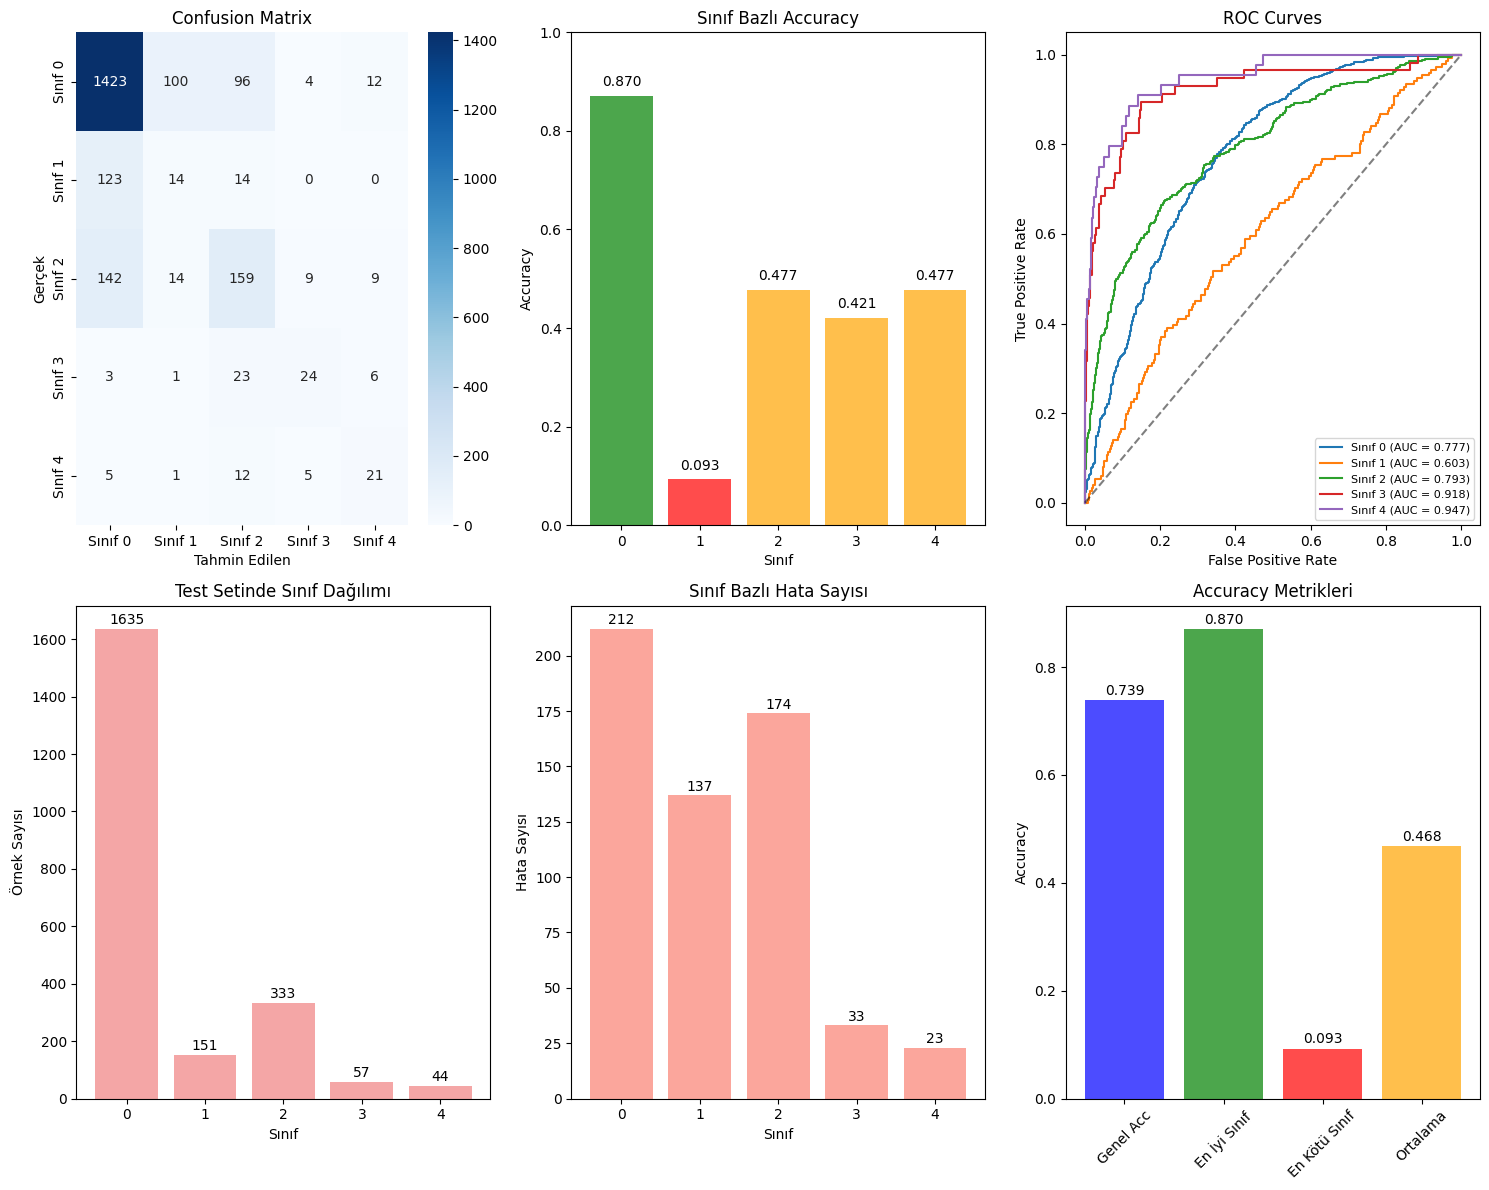


üìã DETAYLI CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Sƒ±nƒ±f 0     0.8390    0.8703    0.8544      1635
     Sƒ±nƒ±f 1     0.1077    0.0927    0.0996       151
     Sƒ±nƒ±f 2     0.5230    0.4775    0.4992       333
     Sƒ±nƒ±f 3     0.5714    0.4211    0.4848        57
     Sƒ±nƒ±f 4     0.4375    0.4773    0.4565        44

    accuracy                         0.7392      2220
   macro avg     0.4957    0.4678    0.4789      2220
weighted avg     0.7271    0.7392    0.7324      2220

üíæ Test sonu√ßlarƒ± CSV'ye kaydedildi: /content/drive/MyDrive/Colab Notebooks/test_results/worker_safe_test_results_20250525_183023.csv

üìä √ñZET ƒ∞STATƒ∞STƒ∞KLER:
üéØ Genel Accuracy: 0.7392
üìà En iyi sƒ±nƒ±f accuracy: 0.8703 (Sƒ±nƒ±f 0)
üìâ En k√∂t√º sƒ±nƒ±f accuracy: 0.0927 (Sƒ±nƒ±f 1)
üìä Ortalama sƒ±nƒ±f accuracy: 0.4678
üìè Standart sapma: 0.2470

üîç HATA ANALƒ∞Zƒ∞:
‚ùå Toplam hata: 579/2220
üìä Hata oranƒ±: 26.08%

üîÑ EN √áOK KARI≈ûTIRILAN

In [ ]:
# H√ºcre: WORKER-SAFE MODEL TEST VE DEƒûERLENDƒ∞RME
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
import os
from datetime import datetime
from torch.utils.data import DataLoader

print("üß™ WORKER-SAFE MODEL TEST VE DEƒûERLENDƒ∞RME")
print("=" * 60)

try:
    # Gerekli deƒüi≈ükenlerin kontrol√º
    required_vars = ['model', 'test_dataset', 'device', 'num_classes']
    for var in required_vars:
        if var not in locals() and var not in globals():
            raise NameError(f"'{var}' deƒüi≈ükeni tanƒ±mlƒ± deƒüil.")

    print("üîß Worker-safe DataLoader olu≈üturuluyor...")

    # WORKER-SAFE TEST DATALOADER
    test_loader_safe = DataLoader(
        test_dataset,
        batch_size=32,  # G√ºvenli batch size
        shuffle=False,  # Test i√ßin shuffle gerekmez
        num_workers=0,  # WORKER SORUNU √á√ñZ√úMLERƒ∞
        pin_memory=False,  # Colab i√ßin g√ºvenli
        persistent_workers=False,  # Worker sorunlarƒ± i√ßin
        drop_last=False  # T√ºm test verilerini kullan
    )

    print("‚úÖ Worker-safe test DataLoader olu≈üturuldu")
    print(f"üìä Test dataset: {len(test_dataset)} √∂rnek")
    print(f"üì¶ Batch size: {test_loader_safe.batch_size}")
    print(f"üë• Workers: {test_loader_safe.num_workers}")

    # Test sonu√ßlarƒ± i√ßin klas√∂r olu≈ütur
    test_results_dir = "/content/drive/MyDrive/Colab Notebooks/test_results"
    os.makedirs(test_results_dir, exist_ok=True)

    # Zaman damgasƒ±
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    print(f"üìÅ Sonu√ßlar kaydedilecek: {test_results_dir}")

    # Model test moduna al
    model.eval()

    # Test deƒüi≈ükenleri
    all_predictions = []
    all_true_labels = []
    all_probabilities = []
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    total_correct = 0
    total_samples = 0

    print("\nüîç WORKER-SAFE test verisi √ºzerinde tahmin yapƒ±lƒ±yor...")

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader_safe):
            try:
                # Ge√ßersiz etiketleri filtrele
                valid_indices = (labels != -1)
                if not valid_indices.any():
                    print(f"    ‚ö†Ô∏è Batch {batch_idx}: Ge√ßersiz etiketler atlandƒ±")
                    continue

                inputs = inputs[valid_indices].to(device, non_blocking=True)
                labels = labels[valid_indices].to(device, non_blocking=True)

                # Tahmin yap
                outputs = model(inputs)
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                # Sonu√ßlarƒ± kaydet
                all_predictions.extend(predicted.cpu().numpy())
                all_true_labels.extend(labels.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())

                # Genel accuracy hesapla
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()

                # Sƒ±nƒ±f bazlƒ± accuracy hesapla
                for i in range(labels.size(0)):
                    label = labels[i].item()
                    if 0 <= label < num_classes:  # Ge√ßerli sƒ±nƒ±f kontrol√º
                        class_total[label] += 1
                        if predicted[i] == label:
                            class_correct[label] += 1

                # ƒ∞lerleme raporu (her 15 batch'te)
                if (batch_idx + 1) % 15 == 0:
                    current_acc = total_correct / total_samples if total_samples > 0 else 0
                    gpu_mem = torch.cuda.memory_allocated() / 1024**3 if device.type == 'cuda' else 0
                    print(f"    ‚úÖ Batch {batch_idx+1}/{len(test_loader_safe)}: "
                          f"Acc: {current_acc:.4f}, "
                          f"Samples: {total_samples}, "
                          f"GPU: {gpu_mem:.1f}GB")

            except Exception as batch_error:
                print(f"    ‚ùå Batch {batch_idx} hatasƒ±: {str(batch_error)}")
                continue

    # Sonu√ßlarƒ± kontrol et
    if len(all_true_labels) == 0:
        print("‚ùå Hi√ß ge√ßerli test verisi bulunamadƒ±!")
        raise ValueError("Test verisi bo≈ü")

    # NumPy array'lere √ßevir
    y_true = np.array(all_true_labels)
    y_pred = np.array(all_predictions)
    y_prob = np.array(all_probabilities)

    # Genel test accuracy
    test_accuracy = total_correct / total_samples if total_samples > 0 else 0

    print(f"\nüéØ WORKER-SAFE TEST SONU√áLARI:")
    print("=" * 45)
    print(f"üìä Genel Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"üìà ƒ∞≈ülenen toplam √∂rnek: {total_samples}")
    print(f"‚úÖ Doƒüru tahmin: {total_correct}")

    # Sƒ±nƒ±f bazlƒ± accuracy
    print(f"\nüìà Sƒ±nƒ±f Bazlƒ± Accuracies:")
    class_accuracies = []
    for i in range(num_classes):
        if class_total[i] > 0:
            class_acc = class_correct[i] / class_total[i]
            class_accuracies.append(class_acc)
            print(f"  Sƒ±nƒ±f {i}: {class_acc:.4f} ({class_acc*100:.1f}%) - {class_total[i]} √∂rnek")
        else:
            class_accuracies.append(0.0)
            print(f"  Sƒ±nƒ±f {i}: 0.0000 (0.0%) - 0 √∂rnek")

    # Confusion Matrix
    print(f"\nüìä Confusion Matrix olu≈üturuluyor...")
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(15, 12))

    # Confusion Matrix grafiƒüi
    plt.subplot(2, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'Sƒ±nƒ±f {i}' for i in range(num_classes)],
                yticklabels=[f'Sƒ±nƒ±f {i}' for i in range(num_classes)])
    plt.title('Confusion Matrix')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Ger√ßek')

    # Sƒ±nƒ±f bazlƒ± accuracy bar grafiƒüi
    plt.subplot(2, 3, 2)
    colors = ['red' if acc < 0.3 else 'orange' if acc < 0.6 else 'green' for acc in class_accuracies]
    plt.bar(range(num_classes), class_accuracies, color=colors, alpha=0.7)
    plt.xlabel('Sƒ±nƒ±f')
    plt.ylabel('Accuracy')
    plt.title('Sƒ±nƒ±f Bazlƒ± Accuracy')
    plt.xticks(range(num_classes))
    plt.ylim(0, 1)
    for i, acc in enumerate(class_accuracies):
        plt.text(i, acc + 0.02, f'{acc:.3f}', ha='center', fontsize=10)

    # ROC Curve (√ßok sƒ±nƒ±flƒ±)
    plt.subplot(2, 3, 3)
    if len(np.unique(y_true)) > 1:  # En az 2 sƒ±nƒ±f varsa
        try:
            y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

            # Her sƒ±nƒ±f i√ßin ROC eƒürisi
            for i in range(min(num_classes, y_prob.shape[1])):
                if i < y_true_bin.shape[1]:
                    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, label=f'Sƒ±nƒ±f {i} (AUC = {roc_auc:.3f})')

            plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curves')
            plt.legend(fontsize=8)
        except Exception as roc_error:
            plt.text(0.5, 0.5, f'ROC hesaplanamadƒ±:\n{str(roc_error)}',
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('ROC Curves (Hata)')
    else:
        plt.text(0.5, 0.5, 'ROC i√ßin yeterli sƒ±nƒ±f yok',
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('ROC Curves (Yetersiz Veri)')

    # Sƒ±nƒ±f daƒüƒ±lƒ±mƒ±
    plt.subplot(2, 3, 4)
    unique, counts = np.unique(y_true, return_counts=True)
    plt.bar(unique, counts, color='lightcoral', alpha=0.7)
    plt.xlabel('Sƒ±nƒ±f')
    plt.ylabel('√ñrnek Sayƒ±sƒ±')
    plt.title('Test Setinde Sƒ±nƒ±f Daƒüƒ±lƒ±mƒ±')
    plt.xticks(unique)
    for i, count in zip(unique, counts):
        plt.text(i, count + max(counts)*0.01, str(count), ha='center')

    # Hata daƒüƒ±lƒ±mƒ±
    plt.subplot(2, 3, 5)
    errors_per_class = [class_total[i] - class_correct[i] for i in range(num_classes)]
    plt.bar(range(num_classes), errors_per_class, color='salmon', alpha=0.7)
    plt.xlabel('Sƒ±nƒ±f')
    plt.ylabel('Hata Sayƒ±sƒ±')
    plt.title('Sƒ±nƒ±f Bazlƒ± Hata Sayƒ±sƒ±')
    plt.xticks(range(num_classes))
    for i, error in enumerate(errors_per_class):
        if error > 0:
            plt.text(i, error + max(errors_per_class)*0.01, str(error), ha='center')

    # Accuracy kar≈üƒ±la≈ütƒ±rmasƒ±
    plt.subplot(2, 3, 6)
    metrics = ['Genel Acc', 'En ƒ∞yi Sƒ±nƒ±f', 'En K√∂t√º Sƒ±nƒ±f', 'Ortalama']
    values = [
        test_accuracy,
        max(class_accuracies) if class_accuracies else 0,
        min(class_accuracies) if class_accuracies else 0,
        np.mean(class_accuracies) if class_accuracies else 0
    ]
    plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'], alpha=0.7)
    plt.ylabel('Accuracy')
    plt.title('Accuracy Metrikleri')
    plt.xticks(rotation=45)
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

    plt.tight_layout()

    # Grafikleri kaydet
    plot_path = os.path.join(test_results_dir, f"worker_safe_test_analysis_{timestamp}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"üìà Test analiz grafiƒüi kaydedildi: {plot_path}")
    plt.show()

    # Detaylƒ± classification report
    print(f"\nüìã DETAYLI CLASSIFICATION REPORT:")
    print("=" * 50)
    try:
        class_names = [f'Sƒ±nƒ±f {i}' for i in range(num_classes)]
        report = classification_report(y_true, y_pred,
                                     target_names=class_names,
                                     digits=4,
                                     zero_division=0)
        print(report)
    except Exception as report_error:
        print(f"Classification report hatasƒ±: {str(report_error)}")

    # Sonu√ßlarƒ± CSV'ye kaydet
    results_df = pd.DataFrame({
        'Sƒ±nƒ±f': range(num_classes),
        'Accuracy': class_accuracies,
        'Toplam_√ñrnek': [class_total[i] for i in range(num_classes)],
        'Doƒüru_Tahmin': [class_correct[i] for i in range(num_classes)],
        'Hata_Sayƒ±sƒ±': [class_total[i] - class_correct[i] for i in range(num_classes)]
    })

    csv_path = os.path.join(test_results_dir, f"worker_safe_test_results_{timestamp}.csv")
    results_df.to_csv(csv_path, index=False)
    print(f"üíæ Test sonu√ßlarƒ± CSV'ye kaydedildi: {csv_path}")

    # √ñzet istatistikler
    print(f"\nüìä √ñZET ƒ∞STATƒ∞STƒ∞KLER:")
    print("=" * 30)
    print(f"üéØ Genel Accuracy: {test_accuracy:.4f}")
    if class_accuracies:
        print(f"üìà En iyi sƒ±nƒ±f accuracy: {max(class_accuracies):.4f} (Sƒ±nƒ±f {np.argmax(class_accuracies)})")
        print(f"üìâ En k√∂t√º sƒ±nƒ±f accuracy: {min(class_accuracies):.4f} (Sƒ±nƒ±f {np.argmin(class_accuracies)})")
        print(f"üìä Ortalama sƒ±nƒ±f accuracy: {np.mean(class_accuracies):.4f}")
        print(f"üìè Standart sapma: {np.std(class_accuracies):.4f}")

    # Hata analizi
    print(f"\nüîç HATA ANALƒ∞Zƒ∞:")
    print("=" * 20)
    total_errors = total_samples - total_correct
    print(f"‚ùå Toplam hata: {total_errors}/{total_samples}")
    print(f"üìä Hata oranƒ±: {(total_errors/total_samples)*100:.2f}%")

    # En √ßok karƒ±≈ütƒ±rƒ±lan sƒ±nƒ±flar
    print(f"\nüîÑ EN √áOK KARI≈ûTIRILAN SINIFLAR:")
    print("=" * 35)
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j and cm[i, j] > 0:
                total_class_i = np.sum(cm[i, :])
                if total_class_i > 0:
                    error_rate = cm[i, j] / total_class_i * 100
                    if error_rate > 10:  # %10'dan fazla karƒ±≈ütƒ±rma
                        print(f"  Sƒ±nƒ±f {i} ‚Üí Sƒ±nƒ±f {j}: {cm[i, j]} hata ({error_rate:.1f}%)")

    print(f"\n‚úÖ WORKER-SAFE test analizi tamamlandƒ±!")
    print(f"üìÅ T√ºm sonu√ßlar ≈üu klas√∂re kaydedildi: {test_results_dir}")
    print(f"üîß Worker sorunlarƒ± √ß√∂z√ºld√º (workers=0)")

except Exception as e:
    print(f"‚ùå Test sƒ±rasƒ±nda hata: {str(e)}")
    import traceback
    traceback.print_exc()

    # Alternatif basit test
    print(f"\nüîÑ Alternatif basit test deneniyor...")
    try:
        model.eval()
        sample_correct = 0
        sample_total = 0

        # Tek tek batch i≈üle
        for i in range(min(10, len(test_dataset))):
            try:
                sample_data = test_dataset[i]
                if len(sample_data) == 2:
                    input_tensor, label = sample_data
                    if label != -1:  # Ge√ßerli etiket
                        input_tensor = input_tensor.unsqueeze(0).to(device)
                        with torch.no_grad():
                            output = model(input_tensor)
                            _, predicted = torch.max(output, 1)
                            sample_total += 1
                            if predicted.item() == label:
                                sample_correct += 1
            except:
                continue

        if sample_total > 0:
            sample_acc = sample_correct / sample_total
            print(f"üéØ Basit test sonucu: {sample_acc:.4f} ({sample_total} √∂rnek)")
        else:
            print("‚ùå Basit test de ba≈üarƒ±sƒ±z")

    except Exception as simple_error:
        print(f"‚ùå Basit test hatasƒ±: {str(simple_error)}")